# Trabalho Prático - O Brasil em Dados
## CCF 425 - INTRODUÇÃO À CIÊNCIA DOS DADOS
## Agrotóxicos no Brasil: análise histórica de aprovação e uso

In [331]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
from unidecode import unidecode
from scipy.stats import norm

import statsmodels.api as sm

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [332]:
anos = map(str, range(2000, 2021))
df = pd.concat([pd.read_excel('data/base.xlsx', sheet_name=ano, usecols='A:M') for ano in anos], ignore_index=True)

In [333]:
df.head(10)

Nº Registro           Processo N° Ano de Protocolo    Data de Protocolo  \
0       100.0                   NaN           1998.0                  NaT   
1       200.0  21000.007322/1998-73           1998.0  1998-11-30 00:00:00   
2       300.0  21000.008308/1997-05           1997.0  1997-12-28 00:00:00   
3       400.0  21000.005665/1998-45           1998.0  1998-10-03 00:00:00   
4       500.0  21000.002296/1998-88           1998.0  1998-04-20 00:00:00   
5       600.0  21000.000532/1999-49           1999.0  1999-02-03 00:00:00   
6       700.0  21000.001953/1999-32           1999.0  1999-04-05 00:00:00   
7       800.0  21000.007321/1998-19           1998.0  1998-11-30 00:00:00   
8       900.0  21000.005393/1996-89           1996.0  1996-11-07 00:00:00   
9      1000.0  21000.004930/1992-77           1992.0  1992-06-10 00:00:00   

                 Marca comercial           Ingrediente Ativo Tipo  \
0                   Nufos 480 CE                 Clorpirifós   PF   
1                          Artea  Ciproconazol; Propiconazol   PF   
2             Azafenidin Técnico                 Azafenidina   PT   
3                  Dinamaz 70 WG                  Imazetapir   PF   
4  Clorpirifós Técnico Cheminova                 Clorpirifós   PT   
5                        Keepdry            Terra Diatomácea   PF   
6                   Primaiz Gold     Atrazina; S-Metolacloro   PF   
7                 Primagram Gold     Atrazina; S-Metolacloro   PF   
8          Pilarsato Técnico 620                   Glifosato   PT   
9               Simazine Técnico                    Simazina   PT   

               Empresa    Data de Aprovação Mês de Deferimento  \
0            Cheminova  2000-01-26 00:00:00                1.0   
1             Novartis  2000-02-04 00:00:00                2.0   
2              Du Pont  2000-02-09 00:00:00                2.0   
3            Cheminova  2000-02-15 00:00:00                2.0   
4            Cheminova  2000-02-18 00:00:00                2.0   
5  Irrigação Dias Cruz  2000-02-22 00:00:00                2.0   
6             Novartis  2000-02-22 00:00:00                2.0   
7             Novartis  2000-02-22 00:00:00                2.0   
8            Pilarquim  2000-02-22 00:00:00                2.0   
9               Sipcam  2000-02-23 00:00:00                2.0   

  Classificação Toxicológica - ANVISA  \
0             I - Extremamente tóxico   
1             I - Extremamente tóxico   
2           III - Medianamente tóxico   
3           III - Medianamente tóxico   
4               II - Altamente tóxico   
5                   IV - Pouco tóxico   
6             I - Extremamente tóxico   
7             I - Extremamente tóxico   
8                   IV - Pouco tóxico   
9           III - Medianamente tóxico   

  Classificação de Periculosidade Ambiental - IBAMA  \
0      II - Produto muito perigoso ao meio ambiente   
1      II - Produto muito perigoso ao meio ambiente   
2           III - Produto perigoso ao meio ambiente   
3           III - Produto perigoso ao meio ambiente   
4      II - Produto muito perigoso ao meio ambiente   
5      IV - Produto pouco perigoso ao meio ambiente   
6      II - Produto muito perigoso ao meio ambiente   
7      II - Produto muito perigoso ao meio ambiente   
8           III - Produto perigoso ao meio ambiente   
9      II - Produto muito perigoso ao meio ambiente   

  Tempo Total de Tramitação (Dias)  Mês Data de Aprovaçcão  
0                              NaN  NaN                NaN  
1                              431  NaN                NaN  
2                              773  NaN                NaN  
3                              500  NaN                NaN  
4                              669  NaN                NaN  
5                              384  NaN                NaN  
6                              323  NaN                NaN  
7                              449  NaN                NaN  
8                             1202  NaN                NaN  

## Preparação dos dados

Nesta análise, combinamos as planilhas contendo os dados de cada ano desde 2000 até 2020 (inclusive). Apesar de termos os dados para o ano de 2021, a planilha ainda não está completa, visto que o ano ainda não acabou. Cada planilha de ano se refere aos agrotóxicos _aprovados_ naquele ano, portanto temos registros _protocolados_ em anos anteriores (começando em 1990) mas aprovados depois.

### Atributos

|Nome|ID da coluna|Tipo|Domínio|
|:---|:-----------|:---|:------|
|Data de Protocolo|`data_protocolo`|numérico intervalo|$[$ `1990-01-01`, `2020-12-31` $]$ |
|Data de Aprovação|`data_aprovacao`|numérico intervalo|$[$ `2000-01-01`, `2020-12-31` $]$ |
|Tempo Total de Tramitação (Dias)|`dias_tramitacao`|numérico razão|$\mathbb{N}$|
|Ingrediente Ativo|`ingrediente`|categórico nominal|$\{$ `glifosato`, `2,4-d`, `fipronil`, $...\}$ (737)|
|Tipo|`tipo`|categórico nominal|$\{$ `PF`,`PT`,`PTN`,`PFN`,`BIO`,`PREMISTURA`,`PTE`,`PF/PTE`,`BIO/ORG` $\}$|
|Empresa|`empresa`|categórico nominal|$\{$ `nortox`, `allier`, `adama`, `syngenta`, $...\}$ (282)|
|Classificação Toxicológica - ANVISA|`classe_anvisa`|categórico ordinal|*|
|Classificação de Periculosidade Ambiental - IBAMA|`classe_ibama`|categórico ordinal|**|
|Período de mandato presidencial***|`periodo`|categórico ordinal|$\{$`1995`,`2003`,`2007`,`2011`,`2015`,`2016`,`2019`$\}$

- Número de Registro: identificador, não é interessante para as análises e será descartado.
- Número do Processo: apenas outro identificador, não é interessante para as análises e será descartado.
- Marca comercial: nome comercial usado pela empresa. Cada valor é quase único por linha, não é interessante para as análises e será descartado.
- Ano de Protocolo: derivado de Data de Protocolo, será descartado.
- Mês de Deferimento (Mês): derivado da Data de Aprovação, será descartado.

#### Observações
\* A classificação toxicológica da ANVISA mudou a partir de 2019. Até antes de 2019, havia uma categoria nominal (`Não classificado - Produto não classificado`) e 4 categorias ordinais:
- `I - Extremamente tóxico`
- `II - Altamente tóxico`
- `III - Medianamente tóxico`
- `IV - Pouco tóxico`

Depois, passou-se a adotar 3 categorias nominais (`Não classificado - Produto não classificado`, `O perfil toxicológico foi considerado equivalente ao produto técnico de referência` e `Não determinada devido à natureza do produto (Inimigos naturais)`), e 5 categorias ordinais:
- `Categoria 1 - Produto Extremamente Tóxico`
- `Categoria 2 - Produto Altamente Tóxico`
- `Categoria 3 - Produto Moderadamente Tóxico`
- `Categoria 4 - Produto Pouco Tóxico`
- `Categoria 5 - Produto Improvável de Causar Dano Agudo`

Por motivos de simplicidade, vamos trocar as categorias ordinais pelos seus valores numéricos (1, 2, 3, 4 e 5). As demais categorias serão trocadas pelos seguintes valores:
- `Não classificado - Produto não classificado` $\implies$ `NC`
- `O perfil toxicológico foi considerado equivalente ao produto técnico de referência` $\implies$ `EQ`
- `Não determinada devido à natureza do produto (Inimigos naturais)` $\implies$ `ND`

\** Essas são as categorias da classificação de periculosidade ambiental do IBAMA:
- `I - Produto altamente perigoso ao meio ambiente`
- `II - Produto muito perigoso ao meio ambiente`
- `III - Produto perigoso ao meio ambiente`
- `IV - Produto pouco perigoso ao meio ambiente`

\*** Os rótulos de mandato presidencial se referem ao ano de início de cada mandato, sendo estes:
- 1995-2003: Fernando Henrique Cardoso
- 2003-2007: Lula (1º mandato)
- 2007-2011: Lula (2º mandato)
- 2011-2015: Dilma Roussef (1º mandato)
- 2015-2016: Dilma Roussef (2º mandato)
- 2016-2019: Michel Temer
- 2019-presente: Jair Bolsonaro

### Formatação

Fizemos as seguintes alterações no DataFrame para formatar os dados:
1. Uma das colunas possuía um erro de digitação (`Data de Aprovaçcão`), então combinamos ela com a coluna correta (`Data de Aprovação`).
2. Descartamos as colunas desnecessárias.
3. Renomeamos as colunas, como descrito na seção anterior.
4. Mudamos os valores de classificação e de tipos para um formato mais simples, como descrito da seção anterior.
5. Adequamos os tipos de cada coluna.
6. Adicionamos o atributo de período de mandato presidencial.

In [334]:
df['Data de Aprovação'] = df['Data de Aprovação'].combine_first(df['Data de Aprovaçcão'])

df.drop(['Nº Registro', 'Processo N°', 'Ano de Protocolo', 'Mês', 'Mês de Deferimento', 'Data de Aprovaçcão'], axis=1, inplace=True, errors='ignore')

columns = {
  'Data de Protocolo': 'data_protocolo',
  'Marca comercial': 'marca', 
  'Ingrediente Ativo': 'ingrediente',
  'Tipo': 'tipo',
  'Empresa': 'empresa',
  'Data de Aprovação': 'data_aprovacao',
  'Classificação Toxicológica - ANVISA': 'classe_anvisa',
  'Classificação de Periculosidade Ambiental - IBAMA': 'classe_ibama',
  'Tempo Total de Tramitação (Dias)': 'dias_tramitacao',
}
df.rename(columns=columns, inplace=True, errors='ignore')

classes_anvisa = {
  'Anulado': None,
  'I - Extremamente tóxico': 'I',
  'II - Altamente tóxico': 'II',
  'III - Medianamente tóxico': 'III',
  'IV - Pouco tóxico': 'IV',
  'Categoria 1 - Produto Extremamente Tóxico': '1',
  'Categoria 2 - Produto Altamente Tóxico': '2',
  'Categoria 3 - Produto Moderadamente Tóxico': '3',
  'Categoria 4 - Produto Pouco Tóxico': '4',
  'Categoria 5 - Produto Improvável de Causar Dano Agudo': '5',
  'Não classificado - Produto não classificado': 'NC',
  'Não Classificado - Produto Não Classificado': 'NC',
  'Não determinada devido à natureza do produto (Inimigos naturais)': 'ND',
  'Não determinada devido à natureza do produto (inimigos naturais)': 'ND',
  'O perfil toxicológico foi considerado equivalente ao produto técnico de referência': 'EQ',
}

classes_ibama = {
  'Anulado': None,
  'I - Produto Altamente Perigoso ao Meio Ambiente': 'I',
  'I - Produto altamente perigoso ao meio ambiente': 'I',
  'II - Produto muito perigoso ao meio ambiente': 'II',
  'II - Produto Muito Perigoso ao Meio Ambiente': 'II',
  'III - Produto perigoso ao meio ambiente': 'III',
  'III - Produto Perigoso ao Meio Ambiente': 'III',
  'IV - Produto pouco perigoso ao meio ambiente': 'IV',
  'IV - Produto Pouco Perigoso ao Meio Ambiente': 'IV',
}

tipos = {
  'Anulado': None,
  'Bio': 'BIO',
  'Pré-Mistura': 'PREMISTURA',
  'Bio/Org': 'BIO/ORG',
  'Pf/PTE': 'PF/PTE',
  'Bio/org': 'BIO/ORG',
}

label_periodos = ['FHC', 'L1', 'L2', 'D1', 'D2', 'MT', 'JB']
anos_periodos = [1995, 2003, 2007, 2011, 2015, 2016, 2019]
def periodo(d):
  if d < datetime.datetime(2003,1,1):
    return 1995
  elif d < datetime.datetime(2007,1,1):
    return 2003
  elif d < datetime.datetime(2011,1,1):
    return 2007
  elif d < datetime.datetime(2015,1,1):
    return 2011
  elif d < datetime.datetime(2016,8,31):
    return 2015
  elif d < datetime.datetime(2019,1,1):
    return 2016
  else:
    return 2019

df.classe_anvisa = df.classe_anvisa.map(lambda x: classes_anvisa.get(x, x), na_action='ignore')
df.classe_ibama = df.classe_ibama.map(lambda x: classes_ibama.get(x, x), na_action='ignore')
df.tipo = df.tipo.map(lambda x: tipos.get(x, x), na_action='ignore')
df.data_protocolo = pd.to_datetime(df.data_protocolo, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df.data_aprovacao = pd.to_datetime(df.data_aprovacao, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df.dias_tramitacao = pd.to_numeric(df.dias_tramitacao, downcast='integer', errors='coerce')
df['periodo'] = df.data_aprovacao.map(periodo)

df.head(10)

data_protocolo                          marca                 ingrediente  \
0            NaT                   Nufos 480 CE                 Clorpirifós   
1     1998-11-30                          Artea  Ciproconazol; Propiconazol   
2     1997-12-28             Azafenidin Técnico                 Azafenidina   
3     1998-10-03                  Dinamaz 70 WG                  Imazetapir   
4     1998-04-20  Clorpirifós Técnico Cheminova                 Clorpirifós   
5     1999-02-03                        Keepdry            Terra Diatomácea   
6     1999-04-05                   Primaiz Gold     Atrazina; S-Metolacloro   
7     1998-11-30                 Primagram Gold     Atrazina; S-Metolacloro   
8     1996-11-07          Pilarsato Técnico 620                   Glifosato   
9     1992-06-10               Simazine Técnico                    Simazina   

  tipo              empresa data_aprovacao classe_anvisa classe_ibama  \
0   PF            Cheminova     2000-01-26             I           II   
1   PF             Novartis     2000-02-04             I           II   
2   PT              Du Pont     2000-02-09           III          III   
3   PF            Cheminova     2000-02-15           III          III   
4   PT            Cheminova     2000-02-18            II           II   
5   PF  Irrigação Dias Cruz     2000-02-22            IV           IV   
6   PF             Novartis     2000-02-22             I           II   
7   PF             Novartis     2000-02-22             I           II   
8   PT            Pilarquim     2000-02-22            IV          III   
9   PT               Sipcam     2000-02-23           III           II   

   dias_tramitacao  periodo  
0              NaN     1995  
1            431.0     1995  
2            773.0     1995  
3            500.0     1995  
4            669.0     1995  
5            384.0     1995  
6            323.0     1995  
7            449.0     1995  
8           1202.0     1995  
9           2814.0     1995

### Ruídos e informações ausentes

Retiramos todas as linhas que possuem algum dos valores nulos. Também limpamos caracteres inválidos e espaços em branco nas extremidades das colunas cujo tipo é string. Para evitar duplicatas, passamos todos esses atributos para caixa baixa, visto que alguns valores apareciam misturados (ex.: `AllierBrasil` e `Allierbrasil`). Por fim, também buscamos possíveis erros de digitação e sufixos desnecessários nos nomes das empresas, pois foram dois tipos de ruído observados com frequência na base de dados e que poderiam influenciar nas análises.

In [335]:
df = df.applymap(lambda x: None if x == 'Anulado' else x)
df = df.dropna()
strcols = ["marca", "ingrediente", "empresa"]
for col in strcols:
  df[col] = df[col].str.replace(u';\xa0', ' ')
  df[col] = df[col].str.replace(u'\xa0', ' ')
  df[col] = df[col].str.replace(u'\u200b', '')
  df[col] = df[col].str.strip()
  df[col] = df[col].str.lower()

In [336]:
renames = {
  'dow agrosciences': 'dow',
  'du pont': 'dupont',
  'chemionova': 'cheminova',
  'pilarquim br': 'pilarquim',
  'sipcam nichino': 'sipcam',
  'laboratotios pfizer': 'pfizer',
  'plato do brasail': 'plato',
  'griffin brasil': 'griffin',
  'rohm': 'rohm and haas',
  'isca tecnologia': 'isca',
  'isca tecnologias': 'isca',
  'agritec': 'agritech',
  'biocontrol': 'bio controle',
  'biocontrole': 'bio controle',
  'allierbrasil': 'allier',
  'crosslinck': 'crosslink',
  'cross link': 'crosslink',
  'cross link consultoria e comercio': 'crosslink',
  'ancon': 'ancom',
  'arysta lifescience': 'arysta',
  'bio soja': 'biosoja',
  'united phosphorus': 'upl',
  'prentis': 'prentiss',
  'volcano agrociencia': 'volcano',
  'sabero organics': 'sabero',
  'iharabras': 'ihara',
  'gembra': 'genbra',
  'luxembutg': 'luxembourg',
  'biothec': 'biotech',
  'cocapeer': 'cocapec',
  'agro import': 'agroimport',
  'prophyto comercio e servicos': 'prophyto',
  'isk biosciences': 'isk',
  'balagro': 'ballagro',
  'koppert do brasil sistemas biologicos': 'koppert',
  'pro-registros': 'proregistros',
  'farroupilha': 'laboratorio de bio controle farroupilha',
  'produtos quimicos sao vicente': 'sao vicente',
  'lemma consultoria': 'lemma',
  'mfb agricola': 'mfb',
  'nellty': 'nelty',
  'oligos biotec': 'oligos',
  'syncrom': 'syncron',
  'nooa ciencia': 'nooa',
  'sulp-mip': 'sul-mip',
  'vital brasil chemical': 'vital',
  'genica inovacao': 'genica'
}

df.empresa = df.empresa.map(lambda e: renames.get(e, e))
df.empresa = df.empresa.map(lambda e: unidecode(e))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' ltda'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' s.a.'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' do brasil'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' brasil'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' quimica'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' agro'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' - america latina'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' america latina'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' industria'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' industria e comercio'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' biotecnologia'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' defensivos agricolas'))
df.empresa = df.empresa.map(lambda e: e.removesuffix(' defensivos'))

In [337]:
# Com estas consultas encontramos os elementos mais frequentes do domínio dos atributos
# de empresa, ingrediente ativo e marca comercial:

def resumo_dominio(col):
  sdf = df.groupby(col).count().sort_values(by="data_protocolo", ascending=False)
  l = list(sdf.reset_index()[col])
  print(f"{col}: ({len(l)}) {l[:4]}")

cols = ["marca", "ingrediente", "empresa"]
for col in cols:
  resumo_dominio(col)

marca: (4029) ['verter', 'attract', 'cougar', 'defend wdg']
ingrediente: (736) ['glifosato', '2,4-d', 'fipronil', 'tebuconazol']
empresa: (282) ['nortox', 'allier', 'adama', 'syngenta']


In [338]:
# Essa etapa de formatação tem que ser executada depois da limpeza
df.ingrediente = df.ingrediente.map(lambda x: list(map(str.strip, x.split(';'))))

In [339]:
df = df[['data_protocolo', 'data_aprovacao', 'periodo', 'dias_tramitacao',
  'ingrediente', 'tipo', 'empresa', 'classe_anvisa', 'classe_ibama']]
df

data_protocolo data_aprovacao  periodo  dias_tramitacao  \
1        1998-11-30     2000-02-04     1995            431.0   
2        1997-12-28     2000-02-09     1995            773.0   
3        1998-10-03     2000-02-15     1995            500.0   
4        1998-04-20     2000-02-18     1995            669.0   
5        1999-02-03     2000-02-22     1995            384.0   
...             ...            ...      ...              ...   
4194     2013-11-27     2020-12-22     2019           2582.0   
4195     2019-11-11     2020-12-22     2019            407.0   
4196     2014-04-08     2020-12-22     2019           2450.0   
4197     2020-07-02     2020-12-22     2019            173.0   
4198     2019-08-14     2020-12-23     2019            497.0   

                                        ingrediente     tipo  \
1                      [ciproconazol, propiconazol]       PF   
2                                     [azafenidina]       PT   
3                                      [imazetapir]       PF   
4                                     [clorpirifós]       PT   
5                                [terra diatomácea]       PF   
...                                             ...      ...   
4194                                [protioconazol]       PF   
4195  [peptídeo derivado de proteína harpin (pdph)]      BIO   
4196                         [triclopir-butotílico]   PF/PTE   
4197                             [telenomus podisi]  BIO/ORG   
4198                           [beauveria bassiana]  BIO/ORG   

                  empresa classe_anvisa classe_ibama  
1                novartis             I           II  
2                  dupont           III          III  
3               cheminova           III          III  
4               cheminova            II           II  
5     irrigacao dias cruz            IV           IV  
...                   ...           ...          ...  
4194                bayer             5           II  
4195         plant health            NC           IV  
4196             stockton             4           II  
4197               topbio            NC           IV  
4198                bioma             5           IV  

[4041 rows x 9 columns]

## Análise Exploratória

> Observação: mesmo antes da filtragem, temos dados apenas dos agrotóxicos que _já foram_ aprovados. Ou seja, registros pendentes não constam no conjunto de dados analisados, o que pode influenciar nas conclusões que chegamos.

É possível observar que o número de agrotóxicos cresceu muito a partir de 2016 (Gráfico 1). Uma comparação de exemplo pode ser feita entre os anos de 2007 (ano com maior quantidade de agrotóxicos aprovados antes de 2016) e 2020 (ano completo mais recente): nota-se que em 2020 a quantidade foi acima do dobro de 2007.

Dentre os agrotóxicos estudados, o ingrediente mais utilizado foi o glifosato (Tabela 1), cujo uso é proibido ou limitado em alguns países [da América Latina](https://www.brasildefato.com.br/2021/02/01/mexico-proibe-herbicida-glifosato-e-outros-paises-do-continente-limitam-seu-uso) e [da Europa](https://g1.globo.com/economia/agronegocios/noticia/2019/07/02/austria-e-o-primeiro-pais-da-ue-a-proibir-o-glifosato-principal-agrotoxico-utilizado-na-producao-de-soja.ghtml). Além disso, algumas das empresas que mais tiveram agrotóxicos aprovados entre 2000 e 2020 foram: Nortox, Allier, Adama, Syngenta, BASF, Bayer, Dow e Ouro Fino (Tabela 2). Especificamente no ano de 2020, as três empresas que figuraram no top 3 foram Allier, Adama e Rainbow (Tabela 3). A Nortox, Allier e Ouro Fino parecem ser empresas brasileiras, sendo a Ouro Fino especificamente mineira, já as demais são multinacionais. Adama era israelense, a BASF e a Bayer são alemãs, a Syngenta era suíça, a Dow é estadunidense (mais tarde se fundiu à DuPont, outra empresa dos EUA), e a Rainbow é chinesa. Vale ressaltar que a Adama foi comprada pelo grupo Syngenta, sendo este também adquirido por outra empresa, a ChemChina, uma empresa estatal chinesa.

> Observação: ao longo das demais análises, ao comparar alguma variável com os ingredientes ativos ou com as empresas, consideramos apenas os 10 mais frequentes, como referência, de acordo com as tabelas 2 e 3. Isso foi necessário visto que são muitos valores únicos.

Quanto às classificações toxicológicas da ANVISA, é possível notar que, a partir de 2016, houve um grande aumento do tipo 1 de classificação - a mais tóxica para a saúde (Gráfico 8). Para comparar, a quantidade de agrotóxicos dessa classificação, dos anos de 2016 a 2019, equivale a aproximadamente o total de todos os aprovados do ano de 2013. No entanto, é visto que, em 2019, novas categorias foram criadas: a categoria 5 - que seria mais leve que a categoria 4 -, a categoria rotulada como EQ - "O perfil toxicológico foi considerado **eq**uivalente ao produto técnico de referência" - e a categoria ND - "**Não determinada** devido à natureza do produto (Inimigos naturais)". No ano de 2020, a categoria 5 e EQ ficaram bem mais frequentes, o que consideramos inesperado dado o histórico recente. É importante ressaltar que essas classificações, em especial a EQ, não são muito evidentes quanto ao significado.

Já em relação às classificações de periculosidade ambiental do IBAMA, tem-se que não há uma grande quantidade da classificação 1, mas é notório o aumento da classificação 2 durante os anos (Gráfico 10).

Nos anos anteriores, os registros de um dado ano eram aprovados ao longo de, geralmente, 5 a 7 anos. Nos anos mais recentes, é mais comum ir até 11 anos adiante. Ou seja, agora é mais comum aprovar registros protocolados em anos mais distantes no passado. Se observarmos apenas o que foi aprovado no próprio ano, é possível ver que também há uma maior frequência de aprovação de agrotóxicos no mesmo ano (Gráfico 12). Relacionando com o ponto anterior, é possível ver como o tempo de aprovação aumenta nos anos mais recentes, porque registros mais antigos estão sendo considerados (Gráfico 14).

O tempo de aprovação dos ingredientes parece semelhante quando agregado (Gráfico 18), mas ao observar em relação ao tempo, nota-se a mesma tendência, de registros mais antigos serem aprovados (Gráfico 19). Observa-se essa mesma tendência para as empresas, classificações toxicológicas e classificações ambientais (Gráficos 21, 23 e 25), com exceção da classe ambiental 4, cujo tempo de aprovação se reduz com o tempo.

Em relação às novas classificações toxicológicas da ANVISA, a EQ está associada a apenas um tipo de agrotóxico, o PTE, o qual é o segundo mais frequente na classificação toxicológica 1. Além disso, os tipos PF, PF/PTE e PTE são os mais frequentes nas classificações de 1 a 3. O tipo BIO e BIO/ORG são os mais frequente nas categorias menos perigosas e, inclusive, o BIO/ORG é predominante na categoria ND (Gráfico 26).

Na classificação de periculosidade ambiental do IBAMA, não há concentração na categoria 1, mas observamos o mesmo trio (PF, PF/PTE e PTE) de tipos sendo os mais frequentes nas classificações altas. O BIO/ORG é o menos perigoso (Gráfico 27). Novamente, para os ingredientes mais utilizados, os mais comuns são o trio já citado (Gráfico 28).

O glifosato e o 2,4-D são os ingredientes ativos que estão mais presentes na classificação toxicológica 1 - como esperado, tendo em vista toda a controvérsia já mencionada sobre o uso do glifosato (Gráfico 29). Na classificação ambiental, vemos uma certa diferença, onde há predominância da classe 3 nos mais comuns, e classe 2 nos demais (Gráfico 30). Para as empresas mais frequentes, temos muitos registros da classe toxicológica 1 e 3 (Gráfico 31), e na classe ambiental, praticamente possui apenas 2 e 3 (Gráfico 32).


In [340]:
ano_aprov = pd.Grouper(key='data_aprovacao', freq='Y')
ano_proto = pd.Grouper(key='data_protocolo', freq='Y')

tipos_color = {
  'PF': '#bf1313', 'PFN': '#e55502', 'PF/PTE': '#efc700',
  'PT': '#3116aa', 'PTN': '#168daa', 'PTE': '#7116aa',
  'BIO': '#43ad71', 'BIO/ORG': '#239341', 'PREMISTURA': '#8c5308'
}

classes_color = {
  'I': '#dd0202', 'II': '#efc700', 'III': '#0face0', 'IV': '#0bce08',
  '1': '#dd0202', '2': '#dd4f02', '3': '#efc700', '4': '#0face0', '5': '#0bce08',
  'NC': '#939393', 'ND': '#739e80', 'EQ': '#7116aa'
}

def color_list(data, colors, sort=True):
  return [colors[v] for v in (sorted(data.unique()) if sort else data)]

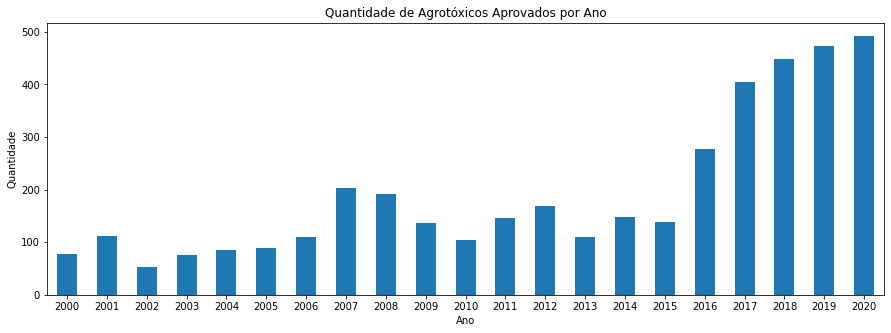

In [341]:
df.groupby([ano_aprov]).size().plot.bar(figsize=(15,5), rot=0)
plt.title('Quantidade de Agrotóxicos Aprovados por Ano')
plt.xlabel('Ano')
plt.xticks(np.arange(21), map(str, range(2000, 2021)))
plt.ylabel('Quantidade')
plt.show()

> Gráfico 1. O número de agrotóxicos aprovados cresceu muito a partir de 2016.

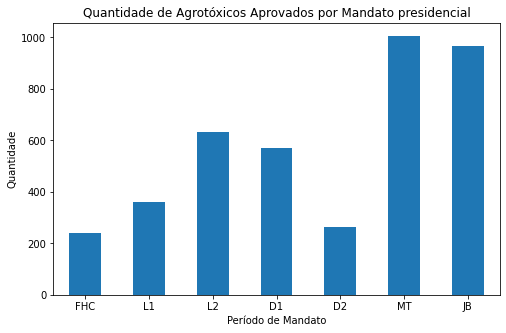

In [342]:
df.groupby(['periodo']).size().plot.bar(figsize=(8,5), rot=0)
plt.title('Quantidade de Agrotóxicos Aprovados por Mandato presidencial')
plt.xlabel('Período de Mandato')
plt.xticks(np.arange(len(label_periodos)), label_periodos)
plt.ylabel('Quantidade')
plt.show()

> Gráfico 2.

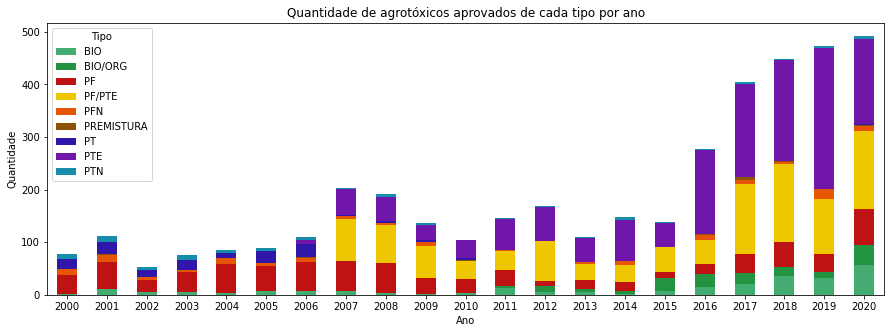

In [343]:
tipos_df = df.groupby([ano_aprov, 'tipo'])['data_aprovacao'].count().unstack('tipo').fillna(0)
tipos_df.columns.name = 'Tipo'
colors = color_list(tipos_df.columns, tipos_color)
ax = tipos_df.plot(kind='bar', stacked=True, figsize=(15,5), rot=0, color=colors)
plt.ylabel('Quantidade')
plt.xlabel('Ano')
plt.title('Quantidade de agrotóxicos aprovados de cada tipo por ano')
plt.xticks(np.arange(21), map(str, range(2000,2021)))
plt.show()

> Gráfico 3.

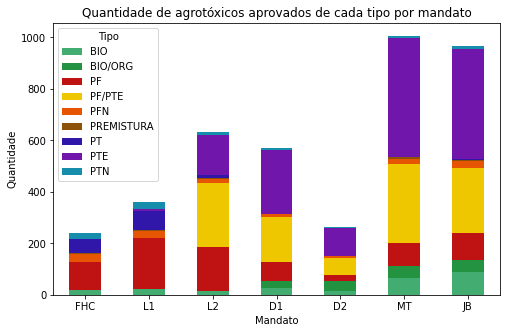

In [344]:
tipos_df = df.groupby(['periodo', 'tipo'])['periodo'].count().unstack('tipo').fillna(0)
tipos_df.columns.name = 'Tipo'
colors = color_list(tipos_df.columns, tipos_color)
ax = tipos_df.plot(kind='bar', stacked=True, figsize=(8,5), rot=0, color=colors)
plt.ylabel('Quantidade')
plt.xlabel('Mandato')
plt.title('Quantidade de agrotóxicos aprovados de cada tipo por mandato')
plt.xticks(np.arange(len(label_periodos)), label_periodos)
plt.show()

> Gráfico 4.

In [345]:
idf = df.explode('ingrediente').groupby(['ingrediente']).count()
idf = idf[['tipo']].rename({'tipo': 'n'}, axis=1).sort_values(by='n', ascending=False)
n = 10
ingr_top, ingr_others = idf[:n], idf[n:]
pd.options.display.max_rows = 11
ingr_top.append(pd.DataFrame({'n': [ingr_others.sum()[0]]}, index=['outros']))

n
glifosato       238
2,4-d           147
fipronil        106
azoxistrobina   102
tebuconazol      95
hexazinona       87
carbendazim      82
diurom           81
mancozebe        77
picloram         77
outros         3510

<table>
  <thead>
    <tr>
      <th colspan=2>Ingredientes ativos mais usados nos agrotóxicos</th>
    </tr>
    <tr>
      <th>Ingrediente ativo</th>
      <th style="text-align: right">Quantidade</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>Glifosato    </td><td style="text-align: right">  238</td></tr>
    <tr><td>2,4-D        </td><td style="text-align: right">  147</td></tr>
    <tr><td>Fipronil     </td><td style="text-align: right">  106</td></tr>
    <tr><td>Azoxistrobina</td><td style="text-align: right">  102</td></tr>
    <tr><td>Tebuconazol  </td><td style="text-align: right">   95</td></tr>
    <tr><td>Hexazinona   </td><td style="text-align: right">   87</td></tr>
    <tr><td>Carbendazim  </td><td style="text-align: right">   82</td></tr>
    <tr><td>Diurom       </td><td style="text-align: right">   81</td></tr>
    <tr><td>Mancozebe    </td><td style="text-align: right">   77</td></tr>
    <tr><td>Picloram     </td><td style="text-align: right">   77</td></tr>
    <tr><td>(outros)     </td><td style="text-align: right"> 3510</td></tr>
  </tbody>
</table>
<br>

> Tabela 1. O ingrediente ativo mais usado foi o glifosato.

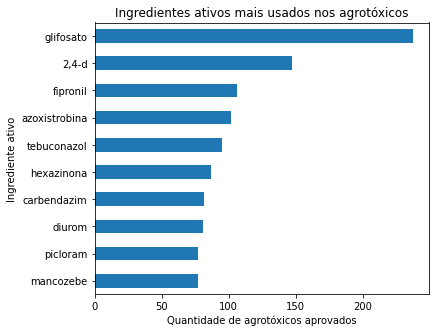

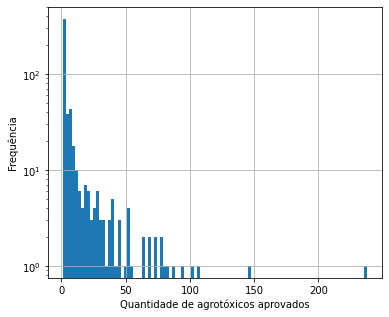

In [346]:
ingr_top.sort_values('n', ascending=True).plot.barh(legend=False, y='n', figsize=(6,5))
plt.title('Ingredientes ativos mais usados nos agrotóxicos')
plt.ylabel('Ingrediente ativo')
plt.xlabel('Quantidade de agrotóxicos aprovados')
plt.show()

idf.hist(bins=100, figsize=(6,5))
plt.title('')
plt.ylabel('Frequência')
plt.xlabel('Quantidade de agrotóxicos aprovados')
plt.yscale('log')
plt.show()

> Gráficos 4 e 5. É possível ver poucos ingredientes ativos sendo usado em muitos agrtóxicos, e muitos ingredientes sendo usados em apenas alguns agrotóxicos.

In [347]:
edf = df.groupby(['empresa']).count()
edf = edf[['tipo']].rename({'tipo': 'n'}, axis=1).sort_values(by='n', ascending=False)
n = 10
emp_top, emp_others = edf[:n], edf[n:]
pd.options.display.max_rows = 20
emp_top.append(pd.DataFrame({'n': [emp_others.sum()[0]]}, index=['outras']))

n
nortox      172
allier      166
adama       148
syngenta    139
basf        138
bayer       137
dow         128
ouro fino   114
ccab        104
rainbow     104
outras     2691

<table>
  <thead>
    <tr>
      <th colspan=2>Empresas que mais tiveram agrotóxicos aprovados de 2000 a 2020</th>
    </tr>
    <tr>
      <th>Empresa</th>
      <th style="text-align: right">Quantidade</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>Nortox       </td><td style="text-align: right">  172</td></tr>
    <tr><td>Allier       </td><td style="text-align: right">  166</td></tr>
    <tr><td>Adama	       </td><td style="text-align: right">  148</td></tr>
    <tr><td>Syngenta     </td><td style="text-align: right">  139</td></tr>
    <tr><td>BASF         </td><td style="text-align: right">  138</td></tr>
    <tr><td>Bayer	       </td><td style="text-align: right">  137</td></tr>
    <tr><td>Dow          </td><td style="text-align: right">  128</td></tr>
    <tr><td>Ouro Fino	   </td><td style="text-align: right">  114</td></tr>
    <tr><td>CCAB         </td><td style="text-align: right">  104</td></tr>
    <tr><td>Rainbow	     </td><td style="text-align: right">  104</td></tr>
    <tr><td>(Outras)     </td><td style="text-align: right"> 2691</td></tr>
  </tbody>
</table>
<br>

> Tabela 2.

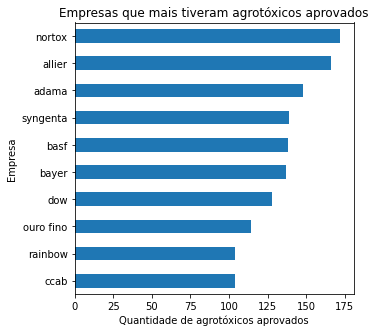

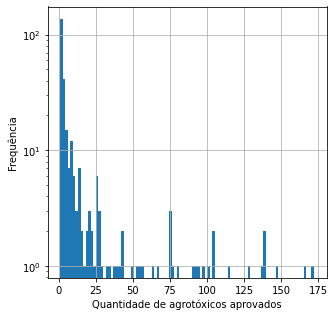

In [348]:
emp_top.sort_values('n', ascending=True).plot.barh(legend=False, y='n')
plt.title('Empresas que mais tiveram agrotóxicos aprovados')
plt.ylabel('Empresa')
plt.xlabel('Quantidade de agrotóxicos aprovados')
plt.show()

ax = edf.hist(bins=100)
plt.title('')
plt.ylabel('Frequência')
plt.xlabel('Quantidade de agrotóxicos aprovados')
plt.yscale('log')
plt.show()

> Gráficos 6 e 7. Aqui também temos menos empresas solicitando registro de muitos agrotóxicos, mas a distribuição se mostra mais longa.

In [349]:
empresas = df.groupby(['empresa', ano_aprov])\
  .count()[['tipo']]\
  .rename({'tipo': 'n'}, axis=1)\
  .reset_index()
for ano in range(2000, 2021):
  print(empresas[empresas.data_aprovacao == datetime.datetime(ano,12,31)]\
    .sort_values(by='n', ascending=False).head(3))

     empresa data_aprovacao   n
183    bayer     2000-12-31  10
428   dupont     2000-12-31   8
1062  zeneca     2000-12-31   6
     empresa data_aprovacao   n
184    bayer     2001-12-31  13
163     basf     2001-12-31  10
21   agricur     2001-12-31   9
     empresa data_aprovacao  n
148  aventis     2002-12-31  6
410      dow     2002-12-31  5
28   agripec     2002-12-31  4
       empresa data_aprovacao  n
29     agripec     2003-12-31  7
165       basf     2003-12-31  7
298  cheminova     2003-12-31  7
     empresa data_aprovacao  n
166     basf     2004-12-31  9
187    bayer     2004-12-31  9
30   agripec     2004-12-31  8
       empresa data_aprovacao   n
188      bayer     2005-12-31  18
953   syngenta     2005-12-31  10
300  cheminova     2005-12-31   5
          empresa data_aprovacao   n
479           fmc     2006-12-31  10
189         bayer     2006-12-31   7
214  bio controle     2006-12-31   7
       empresa data_aprovacao   n
480        fmc     2007-12-31  26
302  chemino

<table>
  <thead>
    <tr>
      <th colspan=14>Empresas que mais tiveram agrotóxicos aprovados por ano</th>
    </tr>
    <tr>
      <th colspan=2>2000</th>
      <th colspan=2>2001</th>
      <th colspan=2>2002</th>
      <th colspan=2>2003</th>
      <th colspan=2>2004</th>
      <th colspan=2>2005</th>
      <th colspan=2>2006</th>
    <tr>
  </thead>
  <tbody>
    <tr><td>Bayer</td><td style="text-align: right">10</td><td>Bayer</td><td style="text-align: right">13</td><td>Aventis</td><td style="text-align: right">6</td><td>Agripec</td><td style="text-align: right">7</td><td>Basf</td><td style="text-align: right">9</td><td>Bayer</td><td style="text-align: right">18</td><td>FMC</td><td style="text-align: right">10</td></tr>
    <tr><td>Dupont</td><td style="text-align: right">8</td><td>Basf</td><td style="text-align: right">10</td><td>Dow</td><td style="text-align: right">5</td><td>Basf</td><td style="text-align: right">7</td><td>Bayer</td><td style="text-align: right">9</td><td>Syngenta</td><td style="text-align: right">10</td><td>Bayer</td><td style="text-align: right">7</td></tr>
    <tr><td>Zeneca</td><td style="text-align: right">6</td><td>Agricur</td><td style="text-align: right">9</td><td>Agripec</td><td style="text-align: right">4</td><td>Cheminova</td><td style="text-align: right">7</td><td>Agripec</td><td style="text-align: right">8</td><td>Cheminova</td><td style="text-align: right">5</td><td>Bio Controle</td><td style="text-align: right">7</td></tr>
  </tbody>
  <thead>
    <tr>
      <th colspan=2>2007</th>
      <th colspan=2>2008</th>
      <th colspan=2>2009</th>
      <th colspan=2>2010</th>
      <th colspan=2>2011</th>
      <th colspan=2>2012</th>
      <th colspan=2>2013</th>
    <tr>
  </thead>
  <tbody>
    <tr><td>FMC</td><td style="text-align: right">26</td><td>Volcano</td><td style="text-align: right">19</td><td>Rotam</td><td style="text-align: right">15</td><td>Ouro Fino</td><td style="text-align: right">9</td><td>Dva</td><td style="text-align: right">10</td><td>Allier</td><td style="text-align: right">13</td><td>Syngenta</td><td style="text-align: right">7</td></tr>
    <tr><td>Cheminova</td><td style="text-align: right">14</td><td>Syngenta</td><td style="text-align: right">15</td><td>Bayer</td><td style="text-align: right">9</td><td>Helm</td><td style="text-align: right">7</td><td>Consagro</td><td style="text-align: right">8</td><td>Milenia</td><td style="text-align: right">10</td><td>Milenia</td><td style="text-align: right">7</td></tr>
    <tr><td>Dupont</td><td style="text-align: right">13</td><td>Bayer</td><td style="text-align: right">14</td><td>Nortox</td><td style="text-align: right">8</td><td>Bayer</td><td style="text-align: right">7</td><td>Syngenta</td><td style="text-align: right">8</td><td>Bra</td><td style="text-align: right">9</td><td>Ihara</td><td style="text-align: right">6</td></tr>

  </tbody>
  <thead>
    <tr>
      <th colspan=2>2014</th>
      <th colspan=2>2015</th>
      <th colspan=2>2016</th>
      <th colspan=2>2017</th>
      <th colspan=2>2018</th>
      <th colspan=2>2019</th>
      <th colspan=2>2020</th>
    <tr>
  </thead>
  <tbody>
    <tr><td>Dow</td><td style="text-align: right">13</td><td>CCAB</td><td style="text-align: right">10</td><td>Allier</td><td style="text-align: right">25</td><td>Allier</td><td style="text-align: right">31</td><td>Adama</td><td style="text-align: right">37</td><td>Adama</td><td style="text-align: right">40</td><td>Allier</td><td style="text-align: right">32</td></tr>
    <tr><td>Ouro Fino</td><td style="text-align: right">9</td><td>Adama</td><td style="text-align: right">9</td><td>CCAB</td><td style="text-align: right">14</td><td>Upl</td><td style="text-align: right">26</td><td>Nortox</td><td style="text-align: right">27</td><td>Nortox</td><td style="text-align: right">33</td><td>Rainbow</td><td style="text-align: right">32</td></tr>
    <tr><td>Alta</td><td style="text-align: right">8</td><td>Rainbow</td><td style="text-align: right">8</td><td>Adama</td><td style="text-align: right">13</td><td>Nortox</td><td style="text-align: right">20</td><td>Allier</td><td style="text-align: right">22</td><td>Rainbow</td><td style="text-align: right">22</td><td>Adama</td><td style="text-align: right">28</td></tr>
  </tbody>
</table>
<br>

> Tabela 3. 

In [350]:
empresas = df.groupby(['empresa', 'periodo'])\
  .count()[['tipo']]\
  .rename({'tipo': 'n'}, axis=1)\
  .reset_index()
for ano in anos_periodos:
  print(empresas[empresas.periodo == ano]\
    .sort_values(by='n', ascending=False).head(5))

     empresa  periodo   n
98     bayer     1995  24
91      basf     1995  17
15   agricur     1995  14
394   nortox     1995  12
373  milenia     1995  12
       empresa  periodo   n
99       bayer     2003  39
543   syngenta     2003  25
92        basf     2003  24
169  cheminova     2003  24
19     agripec     2003  19
       empresa  periodo   n
268        fmc     2007  37
100      bayer     2007  37
93        basf     2007  32
170  cheminova     2007  31
544   syngenta     2007  31
       empresa  periodo   n
47      allier     2011  29
415  ouro fino     2011  25
185   consagro     2011  25
545   syngenta     2011  24
376    milenia     2011  23
    empresa  periodo   n
48   allier     2015  20
161    ccab     2015  17
585     upl     2015  14
407  nufarm     2015  13
4     adama     2015  11
    empresa  periodo   n
5     adama     2016  67
49   allier     2016  63
399  nortox     2016  51
586     upl     2016  41
408  nufarm     2016  37
       empresa  periodo   n
6        ada

<table>
<thead>
    <tr>
      <th colspan=14>Empresas que mais tiveram agrotóxicos aprovados por mandato presidencial</th>
    </tr>
    <tr>
      <th colspan=2>FHC</th>
      <th colspan=2>L1</th>
      <th colspan=2>L2</th>
      <th colspan=2>D1</th>
      <th colspan=2>D2</th>
      <th colspan=2>MT</th>
      <th colspan=2>JB</th>
    <tr>
  </thead>
<tbody>
<tr><td>Bayer</td><td style="text-align: right">24</td><td>Bayer</td><td style="text-align: right">39</td><td>Fmc</td><td style="text-align: right">37</td><td>Allier</td><td style="text-align: right">29</td><td>Allier</td><td style="text-align: right">20</td><td>Adama</td><td style="text-align: right">67</td><td>Adama</td><td style="text-align: right">68</td></tr>
<tr><td>Basf</td><td style="text-align: right">17</td><td>Syngenta</td><td style="text-align: right">25</td><td>Bayer</td><td style="text-align: right">37</td><td>Ouro Fino</td><td style="text-align: right">25</td><td>Ccab</td><td style="text-align: right">17</td><td>Allier</td><td style="text-align: right">63</td><td>Nortox</td><td style="text-align: right">60</td></tr>
<tr><td>Agricur</td><td style="text-align: right">14</td><td>Basf</td><td style="text-align: right">24</td><td>Basf</td><td style="text-align: right">32</td><td>Consagro</td><td style="text-align: right">25</td><td>Upl</td><td style="text-align: right">14</td><td>Nortox</td><td style="text-align: right">51</td><td>Rainbow</td><td style="text-align: right">54</td></tr>
<tr><td>Nortox</td><td style="text-align: right">12</td><td>Cheminova</td><td style="text-align: right">24</td><td>Cheminova</td><td style="text-align: right">31</td><td>Syngenta</td><td style="text-align: right">24</td><td>Nufarm</td><td style="text-align: right">13</td><td>Upl</td><td style="text-align: right">41</td><td>Allier</td><td style="text-align: right">50</td></tr>
<tr><td>Milenia</td><td style="text-align: right">12</td><td>Agripec</td><td style="text-align: right">19</td><td>Syngenta</td><td style="text-align: right">31</td><td>Milenia</td><td style="text-align: right">23</td><td>Adama</td><td style="text-align: right">11</td><td>Nufarm</td><td style="text-align: right">37</td><td>Tradecorp</td><td style="text-align: right">38</td></tr>
</tbody>
</table>

> Tabela 4.

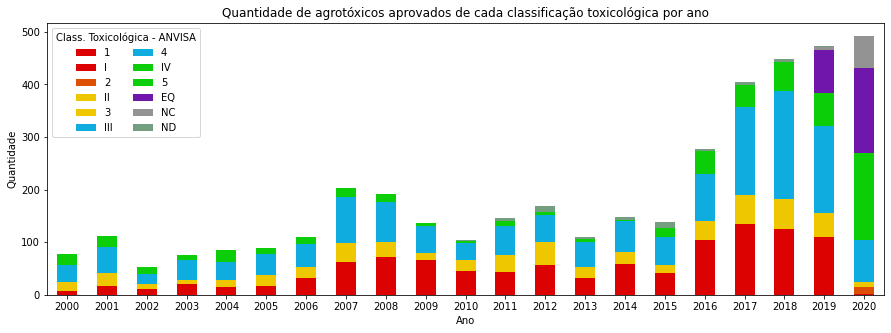

In [351]:
anvisa_order = ['1', 'I', '2', 'II', '3', 'III', '4', 'IV', '5', 'EQ', 'NC', 'ND']
colors = color_list(anvisa_order, classes_color, sort=False)
df_ = df.groupby([ano_aprov, 'classe_anvisa'])['data_aprovacao'].count().unstack('classe_anvisa').fillna(0)[anvisa_order]
ax = df_.plot(kind='bar', stacked=True, figsize=(15,5), rot=0, color=colors)
ax.legend(anvisa_order, ncol=2, title='Class. Toxicológica - ANVISA')
plt.ylabel('Quantidade')
plt.xlabel('Ano')
plt.title('Quantidade de agrotóxicos aprovados de cada classificação toxicológica por ano')
plt.xticks(np.arange(21), range(2000,2021))
plt.show()

> Gráfico 8. Mudança no padrão de agrotóxicos aprovados de cada classificação toxicológica é bastante evidente a partir de 2016 e especialmente a partir de 2019.

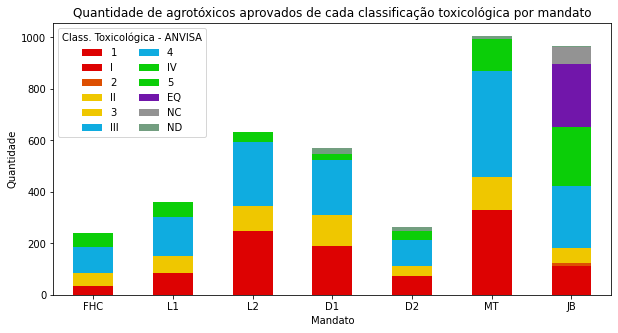

In [352]:
df_ = df.groupby(['periodo', 'classe_anvisa'])['periodo'].count().unstack('classe_anvisa').fillna(0)[anvisa_order]
df_.columns.name = 'Class. Toxicológica - ANVISA'
ax = df_.plot(kind='bar', stacked=True, figsize=(10,5), rot=0, color=colors)
ax.legend(anvisa_order, ncol=2, title='Class. Toxicológica - ANVISA')
plt.ylabel('Quantidade')
plt.xlabel('Mandato')
plt.title('Quantidade de agrotóxicos aprovados de cada classificação toxicológica por mandato')
plt.xticks(np.arange(len(label_periodos)), label_periodos)
plt.show()

> Gráfico 9.

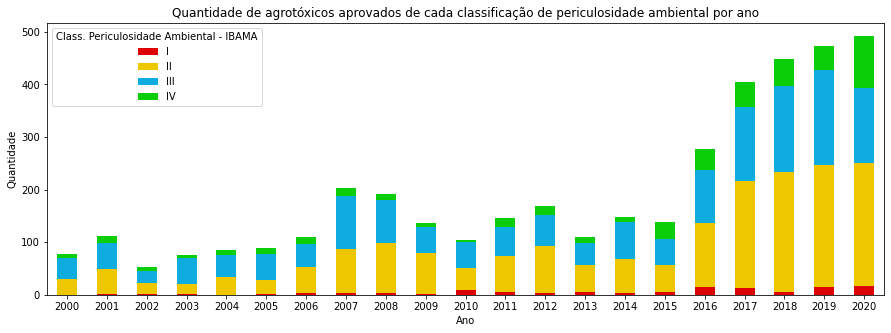

In [353]:
colors = color_list(df.classe_ibama, classes_color)
df_ = df.groupby([ano_aprov, 'classe_ibama'])['data_aprovacao'].count().unstack('classe_ibama').fillna(0)
df_.columns.name = 'Class. Periculosidade Ambiental - IBAMA'
df_.plot(kind='bar', stacked=True, figsize=(15,5), rot=0, color=colors)
plt.ylabel('Quantidade')
plt.xlabel('Ano')
plt.title('Quantidade de agrotóxicos aprovados de cada classificação de periculosidade ambiental por ano')
plt.xticks(np.arange(21), map(str, range(2000,2021)))
plt.show()

> Gráfico 10. 

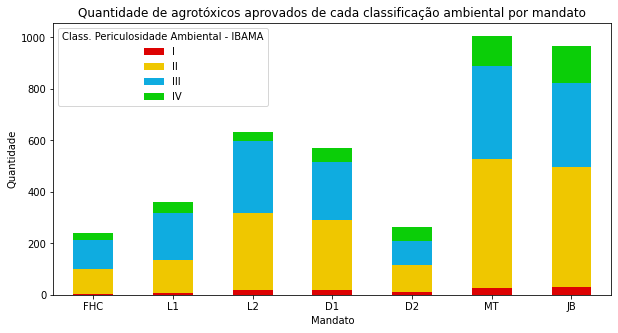

In [354]:
df_ = df.groupby(['periodo', 'classe_ibama'])['periodo'].count().unstack('classe_ibama').fillna(0)
df_.columns.name = 'Class. Periculosidade Ambiental - IBAMA'
df_.plot(kind='bar', stacked=True, figsize=(10,5), rot=0, color=colors)
plt.ylabel('Quantidade')
plt.xlabel('Mandato')
plt.title('Quantidade de agrotóxicos aprovados de cada classificação ambiental por mandato')
plt.xticks(np.arange(len(label_periodos)), label_periodos)
plt.show()

> Gráfico 11.

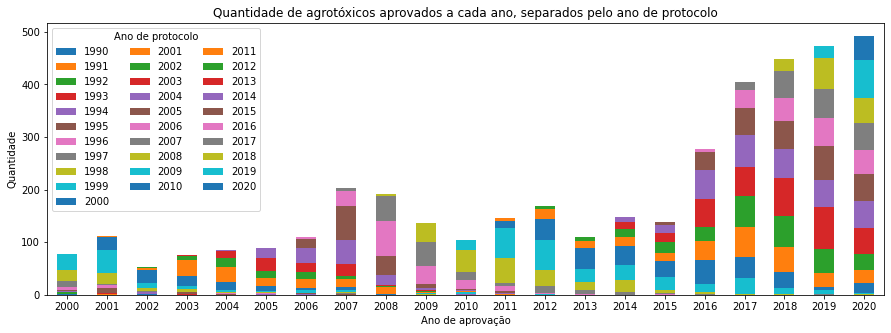

In [355]:

tipos_s = df.groupby([ano_proto, ano_aprov])['data_aprovacao'].count()
tipos_df = tipos_s.unstack('data_protocolo').fillna(0)
ax = tipos_df.plot(kind='bar', stacked=True, figsize=(15,5), rot=0)
ax.legend(range(1990,2021), ncol=3, title='Ano de protocolo')
plt.ylabel('Quantidade')
plt.xlabel('Ano de aprovação')
plt.xticks(np.arange(21), range(2000, 2021))
plt.title('Quantidade de agrotóxicos aprovados a cada ano, separados pelo ano de protocolo')
plt.show()

> Gráfico 12. Registros mais antigos passaram a ser aprovados com mais frequência nos últimos anos. Quantidade de registros protocolados e aprovados no mesmo ano cresceu.

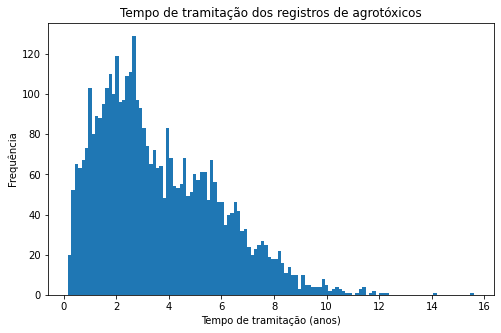

In [356]:
df.dias_tramitacao.map(lambda x: x / 365).plot.hist(bins=120, figsize=(8,5))
plt.title('Tempo de tramitação dos registros de agrotóxicos')
plt.ylabel('Frequência')
plt.xlabel('Tempo de tramitação (anos)')
plt.show()

> Gráfico 13.

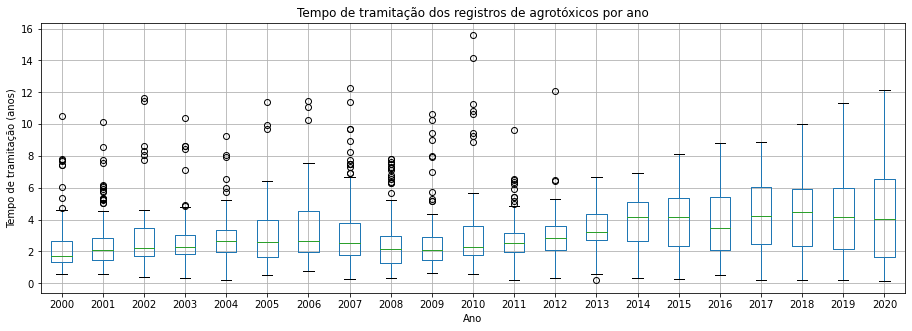

In [357]:
df_ = df.copy()
df_.dias_tramitacao = df_.dias_tramitacao.map(lambda x: x / 365)
df_.boxplot(by=[ano_aprov], column='dias_tramitacao', figsize=(15,5))
plt.suptitle('')
plt.title('Tempo de tramitação dos registros de agrotóxicos por ano')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Ano')
plt.xticks(np.arange(21)+1, map(str, range(2000, 2021)))
plt.show()

> Gráfico 14. Tempo de aprovação nos últimos anos foi aumentando.

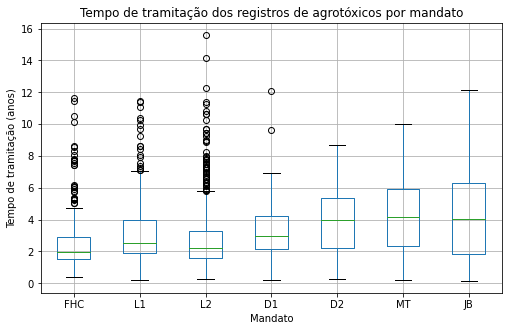

In [358]:
df_.boxplot(by=['periodo'], column='dias_tramitacao', figsize=(8,5))
plt.suptitle('')
plt.title('Tempo de tramitação dos registros de agrotóxicos por mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Mandato')
plt.xticks(np.arange(len(label_periodos))+1, label_periodos)
plt.show()

> Gráfico 15.

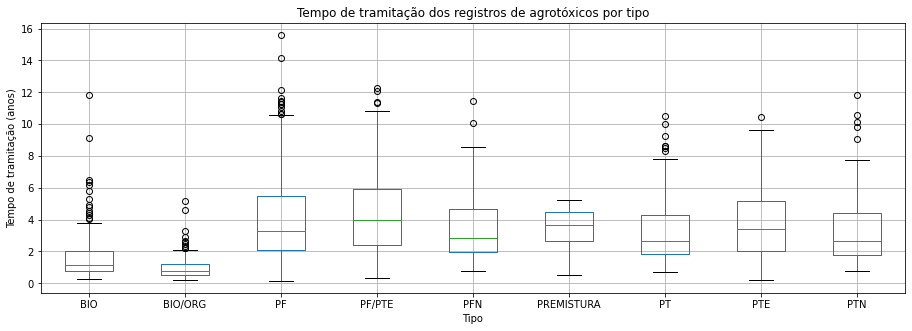

In [359]:
df_.boxplot(by=['tipo'], column='dias_tramitacao', figsize=(15,5))
plt.suptitle('')
plt.title('Tempo de tramitação dos registros de agrotóxicos por tipo')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Tipo')
plt.show()

> Gráfico 16.

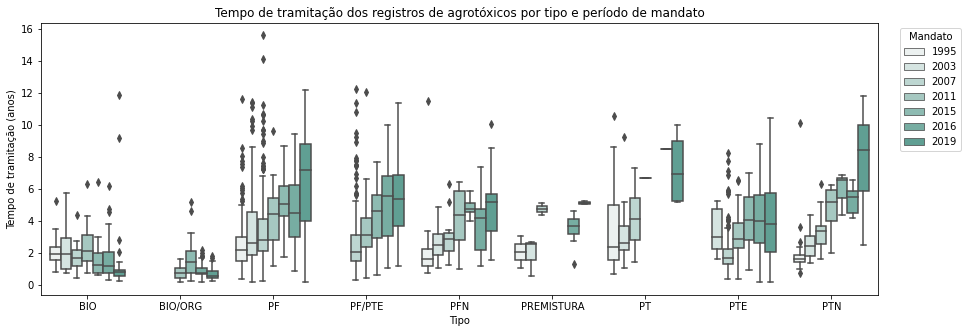

In [360]:
rcParams['figure.figsize'] = (15, 5)
ax = sns.boxplot(data=df_, x="tipo", y="dias_tramitacao", order=sorted(df_.tipo.unique()), hue="periodo", palette="light:#5A9")
ax.legend(bbox_to_anchor= (1.02, 1), title='Mandato')
plt.title('Tempo de tramitação dos registros de agrotóxicos por tipo e período de mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Tipo')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 17. Tendência geral de aumento do tempo de tramitação nos últimos anos é verdade também quando se segmenta pelos tipos dos agrotóxicos, com exceção do tipo BIO ou BIO/ORG.

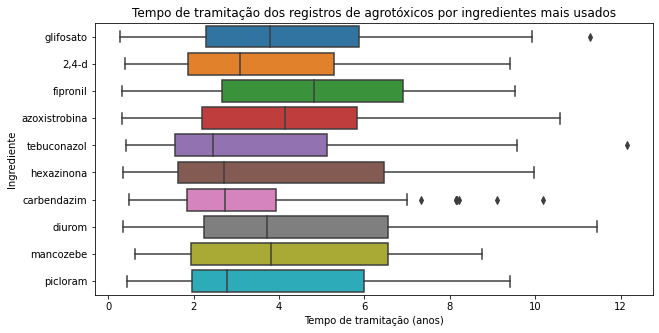

In [361]:
ingr_set = set(ingr_top.index)
ingr_list = list(ingr_top.index)
idf = df_.explode('ingrediente')
rcParams['figure.figsize'] = (10, 5)
sns.boxplot(data=idf[idf.ingrediente.isin(ingr_set)], y="ingrediente", x="dias_tramitacao", order=ingr_list, orient='h')
plt.title('Tempo de tramitação dos registros de agrotóxicos por ingredientes mais usados')
plt.xlabel('Tempo de tramitação (anos)')
plt.ylabel('Ingrediente')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 18.

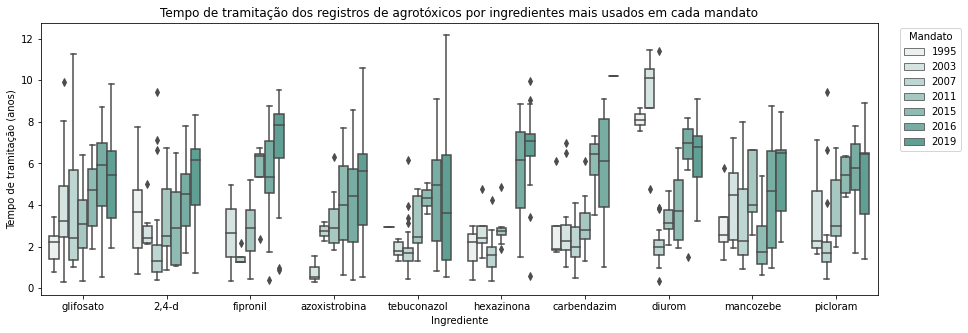

In [362]:
rcParams['figure.figsize'] = (15, 5)
ax = sns.boxplot(data=idf[idf.ingrediente.isin(ingr_set)], x="ingrediente", y="dias_tramitacao", hue="periodo", order=ingr_list, palette="light:#5A9")
ax.legend(bbox_to_anchor= (1.02, 1), title='Mandato')
plt.title('Tempo de tramitação dos registros de agrotóxicos por ingredientes mais usados em cada mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Ingrediente')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 19. Mesma tendência de aumento do tempo de aprovação.

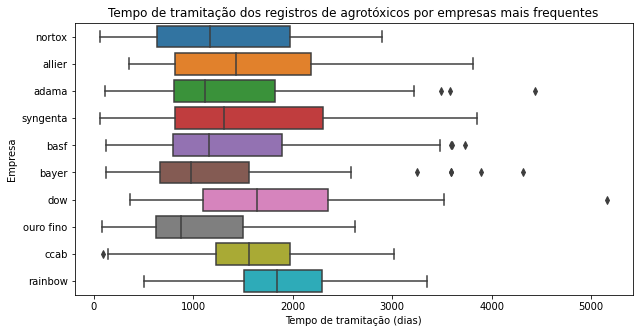

In [363]:
emp_set = set(emp_top.index)
emp_list = list(emp_top.index)
rcParams['figure.figsize'] = (10, 5)
sns.boxplot(data=df[df.empresa.isin(emp_set)], y="empresa", x="dias_tramitacao", order=emp_list, orient='h')
plt.title('Tempo de tramitação dos registros de agrotóxicos por empresas mais frequentes')
plt.xlabel('Tempo de tramitação (dias)')
plt.ylabel('Empresa')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 20.

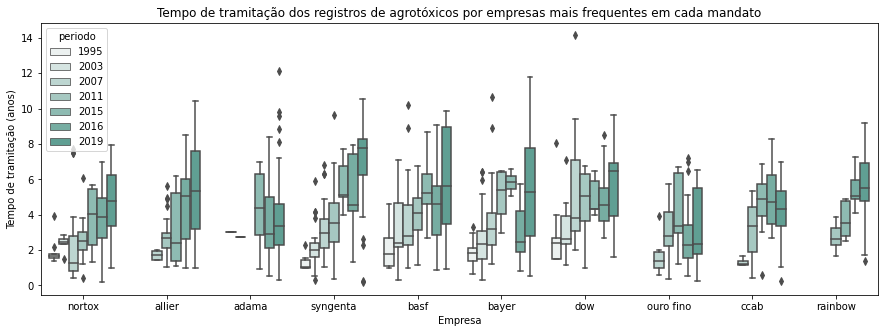

In [364]:
rcParams['figure.figsize'] = (15, 5)
sns.boxplot(data=df_[df_.empresa.isin(emp_set)], x="empresa", y="dias_tramitacao", order=emp_list, hue="periodo", palette="light:#5A9")
plt.title('Tempo de tramitação dos registros de agrotóxicos por empresas mais frequentes em cada mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Empresa')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 21.

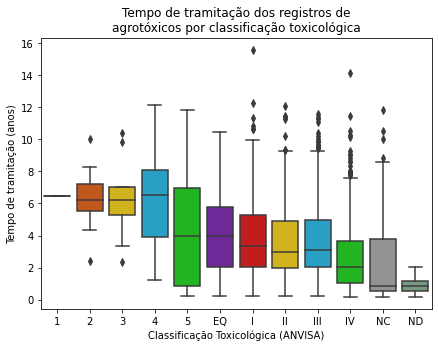

In [365]:
rcParams['figure.figsize'] = (7, 5)
colors = color_list(df_.classe_anvisa, classes_color)
sns.boxplot(data=df_, x="classe_anvisa", y="dias_tramitacao", palette=colors, order=sorted(classes_color.keys()))
plt.title('Tempo de tramitação dos registros de\nagrotóxicos por classificação toxicológica')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Classificação Toxicológica (ANVISA)')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 22.

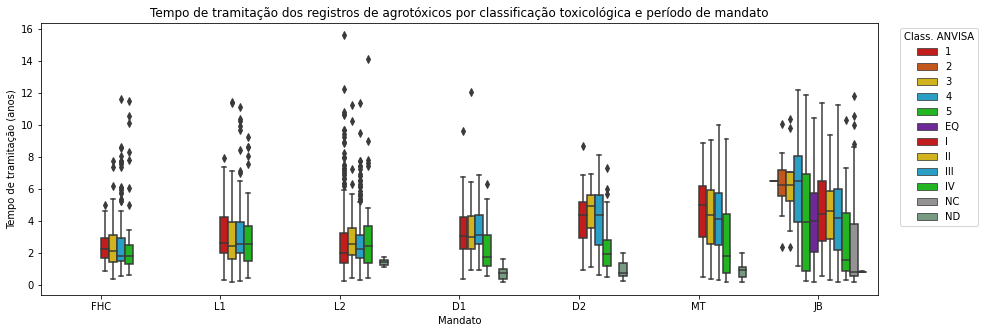

In [366]:
rcParams['figure.figsize'] = (15, 5)
colors = color_list(df_.classe_anvisa, classes_color)
ax = sns.boxplot(data=df_, x="periodo", y="dias_tramitacao", hue="classe_anvisa", palette=colors, hue_order=sorted(classes_color.keys()))
ax.legend(bbox_to_anchor= (1.02, 1), title='Class. ANVISA')
plt.title('Tempo de tramitação dos registros de agrotóxicos por classificação toxicológica e período de mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Mandato')
plt.xticks(np.arange(len(label_periodos)), label_periodos)
plt.show()
rcParams['figure.figsize'] = (5, 5)

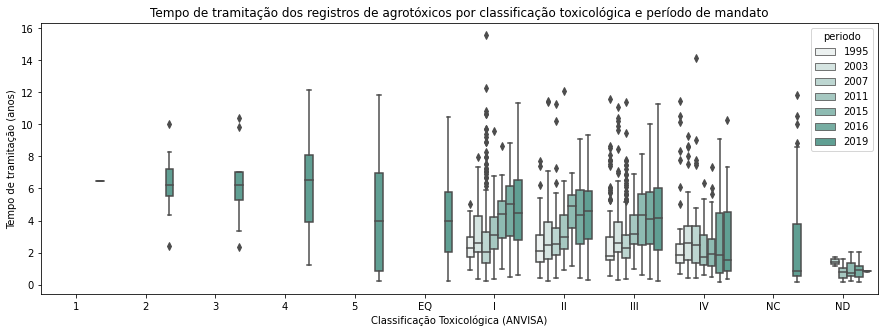

In [367]:
rcParams['figure.figsize'] = (15, 5)
ax = sns.boxplot(data=df_, x="classe_anvisa", y="dias_tramitacao", hue="periodo", order=sorted(classes_color.keys()), palette="light:#5A9")
plt.title('Tempo de tramitação dos registros de agrotóxicos por classificação toxicológica e período de mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Classificação Toxicológica (ANVISA)')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 23.

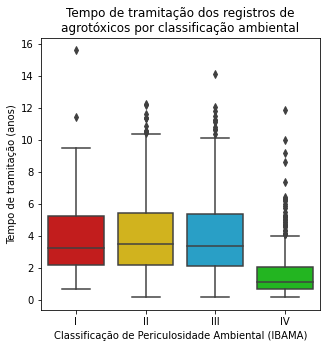

In [368]:
rcParams['figure.figsize'] = (5, 5)
ibama_order = ['I', 'II', 'III', 'IV']
colors = color_list(df_.classe_ibama, classes_color)
sns.boxplot(data=df_, x="classe_ibama", y="dias_tramitacao", order=ibama_order, palette=colors)
plt.title('Tempo de tramitação dos registros de\nagrotóxicos por classificação ambiental')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Classificação de Periculosidade Ambiental (IBAMA)')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 24.

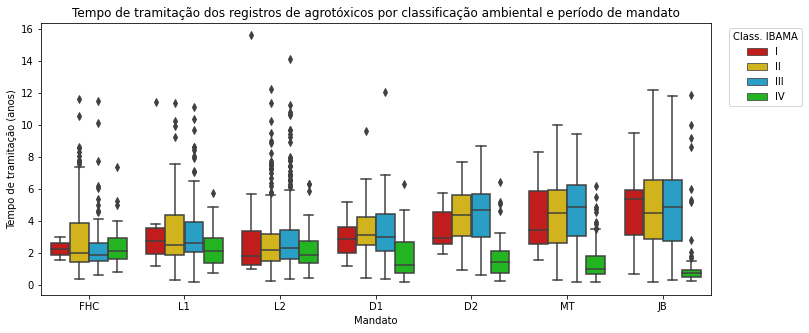

In [369]:
rcParams['figure.figsize'] = (12, 5)
colors = color_list(df_.classe_ibama, classes_color)
ax = sns.boxplot(data=df_, x="periodo", y="dias_tramitacao", hue="classe_ibama", palette=colors, hue_order=ibama_order)
ax.legend(bbox_to_anchor= (1.02, 1), title='Class. IBAMA')
plt.title('Tempo de tramitação dos registros de agrotóxicos por classificação ambiental e período de mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Mandato')
plt.xticks(np.arange(len(label_periodos)), label_periodos)
plt.show()
rcParams['figure.figsize'] = (5, 5)

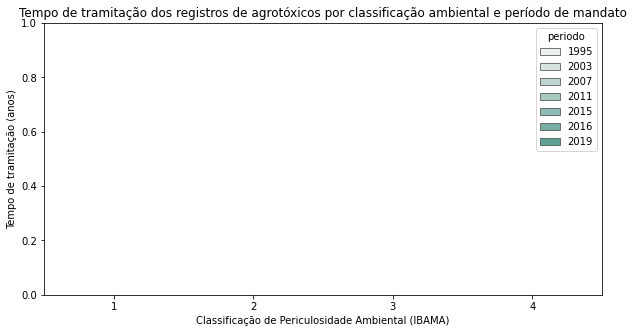

In [370]:
rcParams['figure.figsize'] = (10, 5)
sns.boxplot(data=df_, x="classe_ibama", y="dias_tramitacao", hue="periodo", order=list('1234'), palette="light:#5A9")
plt.title('Tempo de tramitação dos registros de agrotóxicos por classificação ambiental e período de mandato')
plt.ylabel('Tempo de tramitação (anos)')
plt.xlabel('Classificação de Periculosidade Ambiental (IBAMA)')
plt.show()
rcParams['figure.figsize'] = (5, 5)

> Gráfico 25.

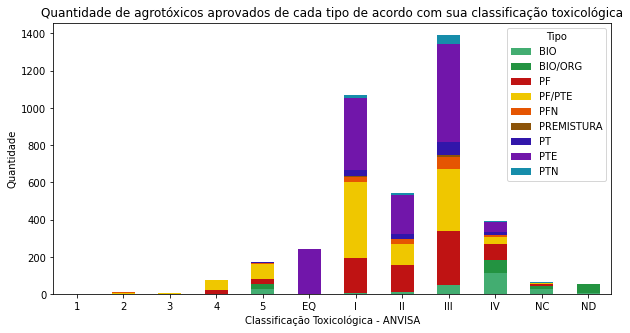

In [371]:
tipos_s = df.groupby(['classe_anvisa', 'tipo'])['classe_anvisa'].count()
tipos_df = tipos_s.unstack('tipo').fillna(0)
tipos_df.columns.name = 'Tipo'
colors = color_list(tipos_df.columns, tipos_color)
ax = tipos_df.plot(kind='bar', stacked=True, figsize=(10,5), rot=0, color=colors)
plt.ylabel('Quantidade')
plt.xlabel('Classificação Toxicológica - ANVISA')
plt.title('Quantidade de agrotóxicos aprovados de cada tipo de acordo com sua classificação toxicológica')
plt.show()

> Gráfico 26.

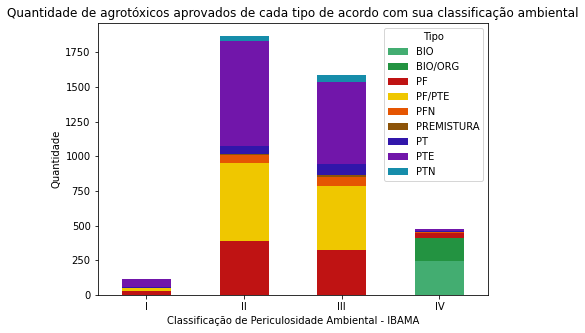

In [372]:
tipos_s = df.groupby(['classe_ibama', 'tipo'])['classe_ibama'].count()
tipos_df = tipos_s.unstack('tipo').fillna(0)
tipos_df.columns.name = 'Tipo'
colors = color_list(tipos_df.columns, tipos_color)
ax = tipos_df.plot(kind='bar', stacked=True, figsize=(7,5), rot=0, color=colors)
plt.ylabel('Quantidade')
plt.xlabel('Classificação de Periculosidade Ambiental - IBAMA')
plt.title('Quantidade de agrotóxicos aprovados de cada tipo de acordo com sua classificação ambiental')
plt.show()

> Gráfico 27.

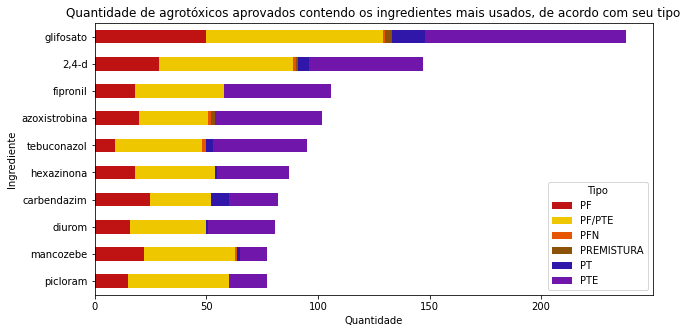

In [373]:
key = {v: i for i, v in enumerate(ingr_top.index)}
df_ = df.explode('ingrediente')
tipos_s = df_[df_.ingrediente.isin(set(ingr_top.index))].groupby(['ingrediente', 'tipo'])['ingrediente'].count()
tipos_df = tipos_s.unstack('tipo').fillna(0)
tipos_df.columns.name = 'Tipo'
colors = color_list(tipos_df.columns, tipos_color)
ax = tipos_df.sort_index(key=lambda x: x.map(lambda x: -key[x]))\
    .plot(kind='barh', stacked=True, figsize=(10,5), rot=0, color=colors)
plt.xlabel('Quantidade')
plt.ylabel('Ingrediente')
plt.title('Quantidade de agrotóxicos aprovados contendo os ingredientes mais usados, de acordo com seu tipo')
plt.show()

> Gráfico 28.

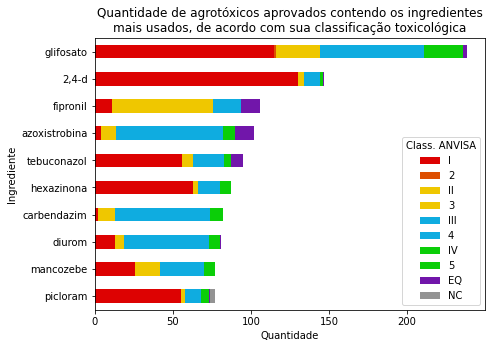

In [374]:
key = {v: i for i, v in enumerate(ingr_top.index)}
df_ = df.explode('ingrediente')
anvisa_order_ = anvisa_order.copy()
anvisa_order_.remove('1')
anvisa_order_.remove('ND')
classes_s = df_[df_.ingrediente.isin(set(ingr_top.index))].groupby(['ingrediente', 'classe_anvisa'])['ingrediente'].count()
classes_df = classes_s.unstack('classe_anvisa').fillna(0)[anvisa_order_]
classes_df.columns.name = 'Class. ANVISA'
colors = color_list(anvisa_order_, classes_color, sort=False)
ax = classes_df.sort_index(key=lambda x: x.map(lambda x: -key[x]))\
    .plot(kind='barh', stacked=True, figsize=(7,5), rot=0, color=colors)
plt.xlabel('Quantidade')
plt.ylabel('Ingrediente')
plt.title('Quantidade de agrotóxicos aprovados contendo os ingredientes\nmais usados, de acordo com sua classificação toxicológica')
plt.show()

> Gráfico 29.

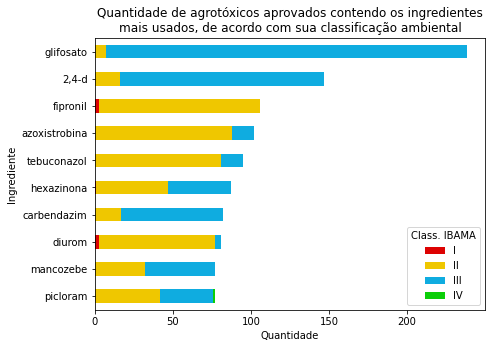

In [375]:
key = {v: i for i, v in enumerate(ingr_top.index)}
df_ = df.explode('ingrediente')
classes_s = df_[df_.ingrediente.isin(set(ingr_top.index))].groupby(['ingrediente', 'classe_ibama'])['ingrediente'].count()
classes_df = classes_s.unstack('classe_ibama').fillna(0)
classes_df.columns.name = 'Class. IBAMA'
colors = color_list(classes_df.columns, classes_color)
ax = classes_df.sort_index(key=lambda x: x.map(lambda x: -key[x]))\
    .plot(kind='barh', stacked=True, figsize=(7,5), rot=0, color=colors)
plt.xlabel('Quantidade')
plt.ylabel('Ingrediente')
plt.title('Quantidade de agrotóxicos aprovados contendo os ingredientes\nmais usados, de acordo com sua classificação ambiental')
plt.show()

> Gráfico 30.

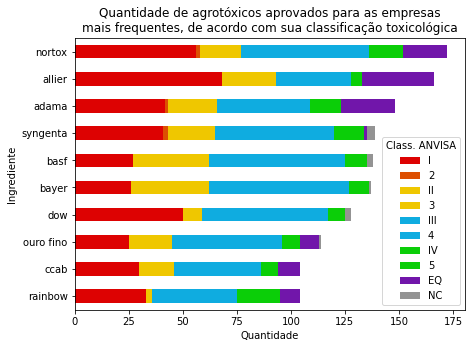

In [376]:
key = {v: i for i, v in enumerate(emp_top.index)}
classes_s = df[df.empresa.isin(set(emp_top.index))].groupby(['empresa', 'classe_anvisa'])['empresa'].count()
classes_df = classes_s.unstack('classe_anvisa').fillna(0)[anvisa_order_]
classes_df.columns.name = 'Class. ANVISA'
colors = color_list(anvisa_order_, classes_color, sort=False)
ax = classes_df.sort_index(key=lambda x: x.map(lambda x: -key[x]))\
    .plot(kind='barh', stacked=True, figsize=(7,5), rot=0,color=colors)
plt.xlabel('Quantidade')
plt.ylabel('Ingrediente')
plt.title('Quantidade de agrotóxicos aprovados para as empresas\nmais frequentes, de acordo com sua classificação toxicológica')
plt.show()

> Gráfico 31.

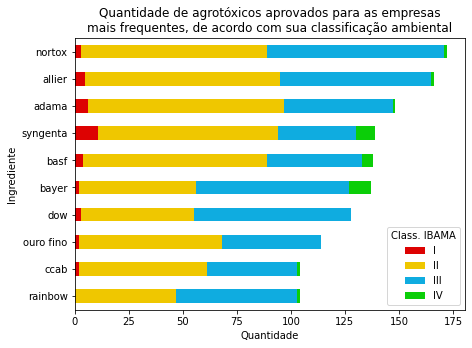

In [377]:
key = {v: i for i, v in enumerate(emp_top.index)}
classes_s = df[df.empresa.isin(set(emp_top.index))].groupby(['empresa', 'classe_ibama'])['empresa'].count()
classes_df = classes_s.unstack('classe_ibama').fillna(0)
classes_df.columns.name = 'Class. IBAMA'
colors = color_list(classes_df.columns, classes_color)
ax = classes_df.sort_index(key=lambda x: x.map(lambda x: -key[x]))\
    .plot(kind='barh', stacked=True, figsize=(7,5), rot=0,color=colors)
plt.xlabel('Quantidade')
plt.ylabel('Ingrediente')
plt.title('Quantidade de agrotóxicos aprovados para as empresas\nmais frequentes, de acordo com sua classificação ambiental')
plt.show()

> Gráfico 32.

## Análise Preditiva

Considerando as mudanças observadas no comportamento do conjunto de dados analisado nos últimos anos (de 2016 pra cá), pretendemos avaliar as seguintes questões:

1. Podemos dizer que com certeza a média de aprovação de agrotóxicos mudou de antes de 2016 para depois de 2016?
2. Podemos prever o tempo de aprovação de novos agrotóxicos com base em suas características?
3. A classificação toxicológica mudou no final de 2019. É possível prever qual seria a classificação dos registros mais recentes se a classificação antiga ainda fosse usada?

### Validação da hipótese de mudança na quantidade de aprovados

Queremos comparar os períodos de mandato presidencial a partir de Michel Temer com todo o período anterior. Para fazer o teste de hipótese e comparar a quantidade de agrotóxicos aprovados, vamos agrupar por mês.

In [378]:
def intervalo_confianca(series):
  mu = series.mean()
  std = series.std()
  ep = std/np.sqrt(len(series))
  print(f"\tErro padrao {ep:.3f}")
  print(f"\tIntervalo de confiança: [{mu-(1.96*ep):.3f} - {mu+(1.96*ep):.3f}]")
  return mu, 1.96 * ep

def comparar_intervalos(sa, sb, label_a, label_b):
  print(f"{label_a}:")
  a_mu, a_ep = intervalo_confianca(sa)
  print(f"{label_b}:")
  b_mu, b_ep = intervalo_confianca(sb)
  x = [a_mu, b_mu]
  y = [1, 3]
  errors = [a_ep, b_ep]
  plt.figure()
  plt.errorbar(x, y, xerr=errors, fmt = 'o', color = 'k')
  plt.yticks((0, 1, 3, 4), ('', label_a, label_b,'')) 
  plt.show()

def ep_2amostras(s1, s2):
  return np.sqrt(s1.std()**2/s1.count() + s2.std()**2/s2.count())

def valor_p(s1, s2, cauda=1):
  return (1 - norm.cdf(abs(s1.mean() - s2.mean()), 0, ep_2amostras(s1, s2)))*cauda

def grafico_dnorm(cond, sigma, label):
  x = np.linspace(norm.ppf(0.0001, 0, sigma), norm.ppf(0.9999, 0, sigma), 100)
  y = norm.pdf(x, 0, sigma)
  eps_range = 3
  eps = [i*sigma for i in range(-eps_range, eps_range + 1)]
  plt.xticks(eps, [f'{i}EP' if i != 0 else '0' for i in range(-eps_range, eps_range + 1)])
  plt.plot(x, y)
  if callable(cond):
    z = x[cond(x)]
    plt.fill_between(z, 0, norm.pdf(z, 0, sigma), color=[(0.6,0.6,0.6)])
  else:
    for c in cond:
      z = x[c(x)]
      plt.fill_between(z, 0, norm.pdf(z, 0, sigma), color=[(0.6,0.6,0.6)])
  for _x in eps:
    plt.vlines(_x, ymin=0, ymax=norm.pdf(_x, 0, sigma), colors=['k'])
  plt.title(label)
  plt.show()

def teste_hipotese(s1, s2, cauda=1):
  dif = s1.mean() - s2.mean()
  ep = ep_2amostras(s1, s2)
  print(f"Diferença entre as médias das amostras: {dif}")
  print(f"Erro padrão das amostras: {ep}")
  print(f"Distância: {dif/ep:.2f} erros padrões")
  print(f"Valor-p: {valor_p(s1, s2, cauda):.4f}")
  if cauda == 2:
    cond = [lambda x: x >= abs(dif), lambda x: x < -abs(dif)]
  elif dif > 0:
    cond = lambda x: x >= dif
  else:
    cond = lambda x: x < dif
  grafico_dnorm(cond, ep, "valor-p")

In [379]:
mes_aprov = pd.Grouper(key='data_aprovacao', freq='m')

df_pre_mt = df[df.periodo < 2016]
df_pos_mt = df[df.periodo >= 2016]

dfc_pre_mt = df_pre_mt.groupby(by=mes_aprov).size()
dfc_pos_mt = df_pos_mt.groupby(by=mes_aprov).size()
print(dfc_pre_mt.describe())
print(dfc_pos_mt.describe())

count    199.000000
mean      10.402010
std        6.632427
min        1.000000
25%        6.000000
50%        9.000000
75%       13.500000
max       44.000000
dtype: float64
count    52.000000
mean     37.903846
std      16.808331
min       4.000000
25%      26.000000
50%      36.000000
75%      46.750000
max      82.000000
dtype: float64


Aprovações antes de 2016:
	Erro padrao 0.470
	Intervalo de confiança: [9.480 - 11.324]
Aprovações depois de 2016:
	Erro padrao 2.331
	Intervalo de confiança: [33.335 - 42.472]


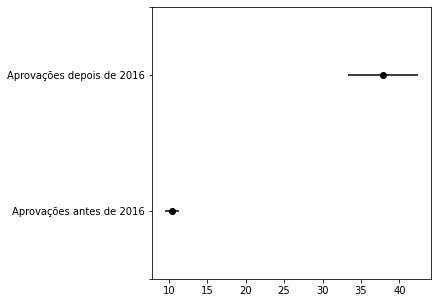

In [380]:
comparar_intervalos(dfc_pre_mt, dfc_pos_mt, 'Aprovações antes de 2016', 'Aprovações depois de 2016')

Vemos claramente pelos intervalos de confiança que a quantidade de aprovados é significativamente diferente entre esses períodos. Para finalizar, faremos um teste de hipótese unicaudal, com nível de significância $\alpha = 0.05$, com as seguintes hipóteses:

- $H_0$: a média de quantidade de agrotóxicos aprovados por mês depois de Michel Temer é a mesma que do período anterior. *(hipótese nula)*
- $H_A$: a média de quantidade de agrotóxicos aprovados por mês depois de Michel Temer é maior que do período anterior. *(hipótese alternativa)*

Analisando o erro padrão entre as duas amostras (célula abaixo), vemos que a distância entre elas é de $11.57$ erros padrões. Logo, a probabilidade de se obter amostras com essa diferença de médias se as populações subjacentes tiverem a mesma média é extremamente baixa.

Observando o valor-p, de $0.00$, temos que $0.00 < \alpha$, logo, rejeitamos a hipótese nula $H_0$. Ou seja, aceitamos a hipótese alternativa $H_A$, concluindo que a quantidade de agrotóxicos aprovados por mês depois de Michel Temer é maior que do período anterior.

Diferença entre as médias das amostras: 27.501836103594897
Erro padrão das amostras: 2.3778408947405185
Distância: 11.57 erros padrões
Valor-p: 0.0000


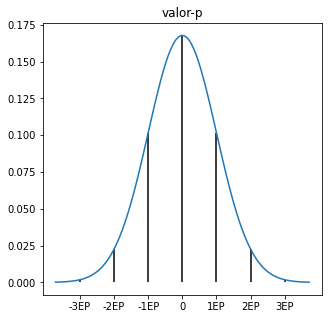

In [381]:
teste_hipotese(dfc_pos_mt, dfc_pre_mt)

### Previsão do tempo de aprovação

Vamos usar apenas os registros após o mandato de Michel Temer, como avaliado no teste de hipótese. Para fazer uma regressão linear, vamos transformar os atributos categóricos (excluindo ingrediente e empresa) em atributos numéricos através de _one hot encoding_. No caso da classificação toxicológica da ANVISA, vamos adaptar para usar apenas a notação nova.

In [382]:
def regressao(y, dfx):
  x = sm.add_constant(dfx)
  results = sm.OLS(y, x).fit()
  print(results.summary())

def onehot(base_df, cols_df, cols):
  dummies = [pd.get_dummies(cols_df[c], prefix=c) for c in cols]
  return pd.concat([base_df] + dummies, join='outer', axis=1)

In [383]:
anvisa_ajuste = {
  'I': '1',
  'II': '3',
  'III': '4',
  'IV': '5',
}

df_pos_mt_ = df_pos_mt.copy()
df_pos_mt_.classe_anvisa = df_pos_mt_.classe_anvisa.map(lambda x: anvisa_ajuste.get(x, x))
df_reg = onehot(df_pos_mt_[['dias_tramitacao']], df_pos_mt_, ['classe_anvisa', 'classe_ibama', 'tipo'])
df_reg

dias_tramitacao  classe_anvisa_1  classe_anvisa_2  classe_anvisa_3  \
2210           1914.0                0                0                1   
2223           1739.0                1                0                0   
2224            259.0                0                0                0   
2225            761.0                0                0                0   
2226           2413.0                1                0                0   
...               ...              ...              ...              ...   
4194           2582.0                0                0                0   
4195            407.0                0                0                0   
4196           2450.0                0                0                0   
4197            173.0                0                0                0   
4198            497.0                0                0                0   

      classe_anvisa_4  classe_anvisa_5  classe_anvisa_EQ  classe_anvisa_NC  \
2210                0                0                 0                 0   
2223                0                0                 0                 0   
2224                0                1                 0                 0   
2225                1                0                 0                 0   
2226                0                0                 0                 0   
...               ...              ...               ...               ...   
4194                0                1                 0                 0   
4195                0                0                 0                 1   
4196                1                0                 0                 0   
4197                0                0                 0                 1   
4198                0                1                 0                 0   

      classe_anvisa_ND  classe_ibama_I  ...  classe_ibama_IV  tipo_BIO  \
2210                 0               1  ...                0         0   
2223                 0               0  ...                0         0   
2224                 0               0  ...                1         0   
2225                 0               0  ...                0         0   
2226                 0               0  ...                0         0   
...                ...             ...  ...              ...       ...   
4194                 0               0  ...                0         0   
4195                 0               0  ...                1         1   
4196                 0               0  ...                0         0   
4197                 0               0  ...                1         0   
4198                 0               0  ...                1         0   

      tipo_BIO/ORG  tipo_PF  tipo_PF/PTE  tipo_PFN  tipo_PREMISTURA  tipo_PT  \
2210             0        0            0         0                0        0   
2223             0        1            0         0                0        0   
2224             1        0            0         0                0        0   
2225             0        1            0         0                0        0   
2226             0        0            0         0                0        0   
...            ...      ...          ...       ...              ...      ...   
4194             0        1            0         0                0        0   
4195             0        0            0         0                0        0   
4196             0        0            1         0                0        0   
4197             1        0            0         0                0        0   
4198             1        0            0         0                0        0   

      tipo_PTE  tipo_PTN  
2210         1         0  
2223         0         0  
2224         0         0  
2225         0         0  
2226         1         0  
...        ...       ...  
4194         0         0  
4195         0         0  
4196         0         0  
4197         0         0  
4198     

In [384]:
excluidas = [
  'dias_tramitacao',
]

regressao(df_reg.dias_tramitacao, df_reg.drop(excluidas, axis=1))

                            OLS Regression Results                            
Dep. Variable:        dias_tramitacao   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     46.89
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          7.16e-138
Time:                        23:26:07   Log-Likelihood:                -15859.
No. Observations:                1971   AIC:                         3.176e+04
Df Residuals:                    1952   BIC:                         3.186e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1141.6137     48.823  

In [385]:
# excluindo atributos com valor-p alto ou intervalo de confiança cruzando o 0.
excluidas = [
  'dias_tramitacao',
  'classe_anvisa_1',
  'classe_anvisa_3',
  'classe_anvisa_4',
  'classe_anvisa_5',
  'classe_anvisa_EQ',
  'classe_anvisa_NC',
  'classe_anvisa_ND',
  'classe_ibama_IV',
  'tipo_PFN',
  'tipo_PREMISTURA',
  'tipo_PTE'
]

regressao(df_reg.dias_tramitacao, df_reg.drop(excluidas, axis=1))

                            OLS Regression Results                            
Dep. Variable:        dias_tramitacao   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     84.02
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          4.61e-144
Time:                        23:26:07   Log-Likelihood:                -15861.
No. Observations:                1971   AIC:                         3.174e+04
Df Residuals:                    1960   BIC:                         3.181e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1126.6086    256.101  

In [386]:
# excluindo outros atributos
excluidas = [
  'dias_tramitacao',
  'classe_anvisa_1',
  'classe_anvisa_3',
  'classe_anvisa_4',
  'classe_anvisa_5',
  'classe_anvisa_EQ',
  'classe_anvisa_NC',
  'classe_anvisa_ND',
  'classe_ibama_I',
  'classe_ibama_II',
  'classe_ibama_III',
  'classe_ibama_IV',
  'tipo_PFN',
  'tipo_PREMISTURA',
  'tipo_PTE'
]

regressao(df_reg.dias_tramitacao, df_reg.drop(excluidas, axis=1))

                            OLS Regression Results                            
Dep. Variable:        dias_tramitacao   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     119.1
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          5.52e-146
Time:                        23:26:07   Log-Likelihood:                -15864.
No. Observations:                1971   AIC:                         3.174e+04
Df Residuals:                    1963   BIC:                         3.179e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1483.7222     24.665     

Após diversos testes com diferentes atributos para fazer a regressão linear, encontramos apenas valores muito baixos de $R^2$ (no máximo $0.3$), o que indica que não parece haver um bom encaixe. Isso corrobora com nossas observações na análise exploratória de que há uma tendência geral de aumento nos últimos anos do tempo de aprovação, sem muita distinção entre os diferentes atributos.

### Previsão da Classificação Toxicológica

Vimos que a partir de agosto de 2019, a classificação da ANVISA foi modificada. Queremos então tentar avaliar se, aprendendo com os registros anteriores a essa alteração, podemos prever a classificação de acordo com o método antigo, em especial porque a categoria EQ não é muito clara quanto ao seu significado.

Devido ao fato de que observamos que os ingredientes ativos parecem ter uma influência quanto à classificação da ANVISA, pretendemos incluí-los inicialmente. Como são muitas categorias possíveis (737), vamos filtrar o conjunto de dados para considerar apenas os 20 ingredientes mais usados. Todos os dados anteriores à alteração da classificação serão usados como treinamento, e os posteriores usados como teste. Ao passo que conseguiremos medir métricas como acurácia e precisão para o treinamento, isso não é possível para o conjunto de treino, devido às categorias novas. No entanto, poderemos observar se o modelo conseguiu prever categorias que fazem sentido (por exemplo, a classificação I corresponde à 1 ou 2, a classificação II corresponde à 3, etc) e como ficaram classificados os registros da classificação EQ.

In [393]:
# Separação dos conjuntos
anvisa_antiga = {'I', 'II', 'III', 'IV'}
anvisa_nova = {'1', '2', '3', '4', '5', 'EQ', 'NC'}
idf = df.explode('ingrediente')
ingr_top = idf.ingrediente.value_counts()[:20]
ingr_set = set(ingr_top.index)
ingr_list = list(ingr_top.index)
df_ = idf[idf.ingrediente.isin(ingr_set)]
df_ = onehot(df_[['classe_anvisa', 'dias_tramitacao']], df_, ['ingrediente', 'tipo', 'classe_ibama'])
train_df = df_[df_.classe_anvisa.isin(anvisa_antiga)]
test_df = df_[df_.classe_anvisa.isin(anvisa_nova)]
print(f'Tamanho do conjunto de treinamento: {len(train_df):5d}')
print(f'Tamanho do conjunto de teste:       {len(test_df):5d}')
print(f'Total:                              {len(df_):5d}')
df_

Tamanho do conjunto de treinamento:  1548
Tamanho do conjunto de teste:         166
Total:                               1714


classe_anvisa  dias_tramitacao  ingrediente_2,4-d  ingrediente_acefato  \
3              III            500.0                  0                    0   
6                I            323.0                  0                    0   
7                I            449.0                  0                    0   
8               IV           1202.0                  0                    0   
10               I            807.0                  0                    0   
...            ...              ...                ...                  ...   
4160             5            161.0                  0                    0   
4161             5            711.0                  0                    0   
4162             4            629.0                  0                    0   
4173             5             86.0                  0                    0   
4188             5           2822.0                  0                    0   

      ingrediente_acetamiprido  ingrediente_atrazina  \
3                            0                     0   
6                            0                     1   
7                            0                     1   
8                            0                     0   
10                           0                     0   
...                        ...                   ...   
4160                         0                     0   
4161                         0                     0   
4162                         0                     1   
4173                         0                     0   
4188                         0                     0   

      ingrediente_azoxistrobina  ingrediente_carbendazim  \
3                             0                        0   
6                             0                        0   
7                             0                        0   
8                             0                        0   
10                            0                        0   
...                         ...                      ...   
4160                          0                        0   
4161                          0                        0   
4162                          0                        0   
4173                          0                        0   
4188                          1                        0   

      ingrediente_clorotalonil  ingrediente_diurom  ...  tipo_PF/PTE  \
3                            0                   0  ...            0   
6                            0                   0  ...            0   
7                            0                   0  ...            0   
8                            0                   0  ...            0   
10                           0                   0  ...            0   
...                        ...                 ...  ...          ...   
4160                         0                   0  ...            0   
4161                         0                   0  ...            1   
4162                         0                   0  ...            1   
4173                         0                   0  ...            0   
4188                         0                   0  ...            0   

      tipo_PFN  tipo_PREMISTURA  tipo_PT  tipo_PTE  tipo_PTN  classe_ibama_I  \
3            0                0        0         0         0               0   
6            0                0        0         0         0               0   
7            0                0        0         0         0               0   
8            0                0        1         0         0               0   
10           0                0        0         0         0               0   
...        ...              ...      ...       ...       ...             ...   
4160         0                0        0         0         0               0   
4161         0                0        0         0         0               0   
4162         0                0        0         0         0               0 

In [388]:
col_names = sorted(anvisa_nova)
m_index = sorted(anvisa_antiga)
idx_a = {v: i for i, v in enumerate(m_index)}
idx_n = {v: i for i, v in enumerate(col_names)}
esperado = {'1': 'I', '2': 'I', '3': 'II', '4': 'III', '5': 'IV'}

def matriz_de_confusao(pred_y, true_y):
  m = [[0 for _ in col_names] for _ in m_index]
  for p, t in zip(pred_y, true_y):
    m[idx_a[p]][idx_n[t]] += 1
  mc = pd.DataFrame(m, columns=col_names, index=m_index)
  return mc

def adaptar_teste(test_y, pred_y):
  df = pd.DataFrame({'test': test_y.to_numpy(), 'pred': pred_y})
  df = df[df.test.isin(esperado)]
  df.test = df.test.map(esperado)
  return df.test, df.pred

def classificar(alg, label, exc=[]):
  train_x, train_y = train_df.drop(['classe_anvisa'] + exc, axis=1), train_df.classe_anvisa
  test_x, test_y = test_df.drop(['classe_anvisa'] + exc, axis=1), test_df.classe_anvisa
  alg.fit(train_x, train_y)
  pred_y = alg.predict(train_x)
  print(f'==> Métricas para o algoritmo {label}, no próprio conjunto de treinamento')
  print(metrics.classification_report(train_y, pred_y))
  print(f'==> Métricas para o algoritmo {label}, no conjunto de teste')
  print(metrics.classification_report(*adaptar_teste(test_y, alg.predict(test_x))))
  return matriz_de_confusao(alg.predict(test_x), test_y)

In [394]:
dtc = DecisionTreeClassifier(random_state=0)
classificar(dtc, 'Árvore de Decisão')

==> Métricas para o algoritmo Árvore de Decisão, no próprio conjunto de treinamento
              precision    recall  f1-score   support

           I       1.00      1.00      1.00       606
          II       0.99      1.00      0.99       252
         III       1.00      0.99      1.00       594
          IV       1.00      0.98      0.99        96

    accuracy                           1.00      1548
   macro avg       1.00      0.99      0.99      1548
weighted avg       1.00      1.00      1.00      1548

==> Métricas para o algoritmo Árvore de Decisão, no conjunto de teste
              precision    recall  f1-score   support

           I       0.08      0.75      0.14         4
          II       0.10      0.33      0.15         3
         III       0.22      0.23      0.22        31
          IV       0.87      0.23      0.36        57

    accuracy                           0.25        95
   macro avg       0.32      0.38      0.22        95
weighted avg       0.60      0.

1  2  3   4   5  EQ  NC
I    0  3  1  17  17  20   1
II   0  0  1   5   4  19   1
III  0  1  1   7  23  26   1
IV   0  0  0   2  13   0   3

In [390]:
svm = LinearSVC(random_state=0)
classificar(svm, 'SVM')

==> Métricas para o algoritmo SVM, no próprio conjunto de treinamento
              precision    recall  f1-score   support

           I       0.39      0.96      0.56       682
          II       0.00      0.00      0.00       320
         III       0.61      0.13      0.21       739
          IV       0.89      0.43      0.58       153

    accuracy                           0.43      1894
   macro avg       0.47      0.38      0.34      1894
weighted avg       0.45      0.43      0.33      1894

==> Métricas para o algoritmo SVM, no conjunto de teste
              precision    recall  f1-score   support

           I       0.05      1.00      0.10         6
          II       0.00      0.00      0.00         4
         III       1.00      0.02      0.04        49
          IV       1.00      0.38      0.55        92

    accuracy                           0.28       151
   macro avg       0.51      0.35      0.17       151
weighted avg       0.94      0.28      0.35       151



1  2  3   4   5  EQ  NC
I    0  6  4  48  57  97   8
II   0  0  0   0   0   0   0
III  0  0  0   1   0   4   0
IV   0  0  0   0  35   0   1

In [395]:
svm = LinearSVC(random_state=0, penalty='l1', dual=False)
classificar(svm, 'SVM')

==> Métricas para o algoritmo SVM, no próprio conjunto de treinamento
              precision    recall  f1-score   support

           I       0.71      0.83      0.76       606
          II       0.56      0.48      0.52       252
         III       0.70      0.69      0.69       594
          IV       0.93      0.39      0.54        96

    accuracy                           0.69      1548
   macro avg       0.72      0.60      0.63      1548
weighted avg       0.69      0.69      0.68      1548

==> Métricas para o algoritmo SVM, no conjunto de teste
              precision    recall  f1-score   support

           I       0.11      1.00      0.20         4
          II       0.33      1.00      0.50         3
         III       0.31      0.35      0.33        31
          IV       1.00      0.25      0.39        57

    accuracy                           0.34        95
   macro avg       0.44      0.65      0.36        95
weighted avg       0.72      0.34      0.37        95



1  2  3   4   5  EQ  NC
I    0  4  0  17  16  22   3
II   0  0  3   3   3  18   2
III  0  0  0  11  24  25   1
IV   0  0  0   0  14   0   0

> Nas métricas para o conjunto de teste, adaptamos para apenas as classificações 1 a 5, que tem correspondência na classificação antiga. Devido ao fato de que a categoria 2 possui a mesma tarja vermelha que a categoria 1, associamos as duas à classificação I. 

Podemos observar que, testando diferentes algoritmos de aprendizado supervisionado, com diferentes parâmetros, quando temos modelos com valor bom de acurácia e demais métricas para o conjunto de treinamento, o resultado não é bom no conjunto de teste. E o inverso também ocorre, na primeira tentativa com o SVM tivemos métricas baixas no treinamento, mas em compensação a classificação no conjunto de testes melhorou, apesar de não ser uma melhora muito significativa. Foram testadas também outras configurações de atributos, mas sem sucesso em melhorar o modelo.

A partir disso, concluímos então que não parece haver uma forma de prever a classificação toxicológica dos registros atuais com base em suas outras características. Isso pode ocorrer tanto por de fato não haver conexão entre esses atributos, ou porque a metodologia para a classificação mudou. Outra possibilidade seria a falta de mais ingredientes para comparar, ou mesmo problemas com a modelagem, pois talvez o one hot encoding não seja suficiente neste contexto.

In [396]:
df_ = idf[idf.ingrediente.isin(ingr_set)]
df_ = onehot(df_[['classe_anvisa', 'dias_tramitacao']], df_, ['ingrediente'])
train_df = df_[df_.classe_anvisa.isin(anvisa_antiga)]
test_df = df_[df_.classe_anvisa.isin(anvisa_nova)]
print(f'Tamanho do conjunto de treinamento: {len(train_df):5d}')
print(f'Tamanho do conjunto de teste:       {len(test_df):5d}')
print(f'Total:                              {len(df_):5d}')

dtc = DecisionTreeClassifier(random_state=0)
classificar(dtc, 'Árvore de Decisão')

Tamanho do conjunto de treinamento:  1548
Tamanho do conjunto de teste:         166
Total:                               1714
==> Métricas para o algoritmo Árvore de Decisão, no próprio conjunto de treinamento
              precision    recall  f1-score   support

           I       0.98      1.00      0.99       606
          II       0.97      0.99      0.98       252
         III       0.99      0.98      0.99       594
          IV       0.99      0.95      0.97        96

    accuracy                           0.99      1548
   macro avg       0.98      0.98      0.98      1548
weighted avg       0.99      0.99      0.99      1548

==> Métricas para o algoritmo Árvore de Decisão, no conjunto de teste
              precision    recall  f1-score   support

           I       0.10      1.00      0.18         4
          II       0.10      0.33      0.15         3
         III       0.34      0.32      0.33        31
          IV       0.80      0.21      0.33        57

    accuracy 

1  2  3   4   5  EQ  NC
I    0  4  1  16  20  19   5
II   0  0  1   2   7  17   0
III  0  0  1  10  18  28   1
IV   0  0  0   3  12   1   0